In [1]:
import numpy as np

# Predict Air Pollution II - predict sequences

#### Exercise objectives
- Work with sequences of different lengths
- Use RNNs to return outputs for each observation in the sequences

<hr>

This exercise is a little bit different from the previous one: Here, you **observe _only_ the weather features (not the pollution)**, and you will **predict one value of air pollution *for each observation* in the input sequence**. 

What is the use-case? 
- Let's say that you have devices that are able to measure the air pollution in some places and to relate it to some weather features. That is fine! 
- But in another place, you have only weather measurements and no way to measure the air pollution.
- Then, you will use the relation between the weather features and the air pollution in some places to be able to predict the air pollution based on the weather features in another places. 

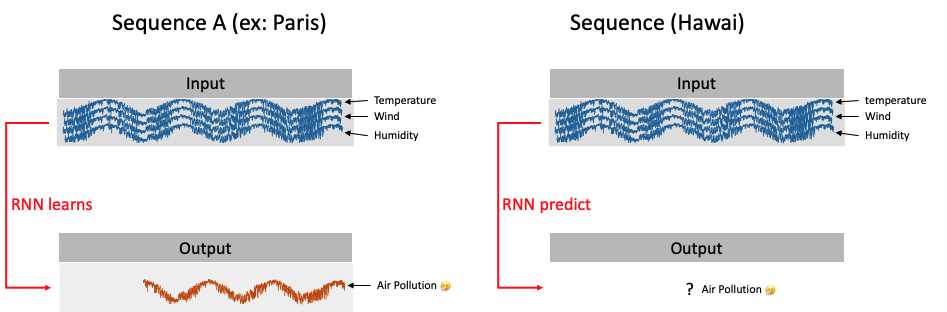

## 1. Data

👇 We load below the same dataset than in previous challenge. `pm2.5` is your target column. This time, it will not be a feature

In [102]:
import pandas as pd
df = pd.read_csv('data.txt', index_col=[0])
df = df[['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']]
df

pm2.5  TEMP  DEWP    PRES  Ir  Is     Iws
No                                              
1        NaN -11.0   -21  1021.0   0   0    1.79
2        NaN -12.0   -21  1020.0   0   0    4.92
3        NaN -11.0   -21  1019.0   0   0    6.71
4        NaN -14.0   -21  1019.0   0   0    9.84
5        NaN -12.0   -20  1018.0   0   0   12.97
...      ...   ...   ...     ...  ..  ..     ...
43820    8.0  -2.0   -23  1034.0   0   0  231.97
43821   10.0  -3.0   -22  1034.0   0   0  237.78
43822   10.0  -3.0   -22  1034.0   0   0  242.70
43823    8.0  -4.0   -22  1034.0   0   0  246.72
43824   12.0  -3.0   -21  1034.0   0   0  249.85

[43824 rows x 7 columns]

We separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe are in the training. And the last 20% in the test set. We also scale the data so as to have them in the same range

In [118]:
split_index = int(len(df)*0.8)
df_train = df[:split_index]
df_test = df[split_index:]

In [119]:
# Scale with MinMaxScale
from sklearn.preprocessing import MinMaxScaler
columns = df.columns

scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_train.head()

pm2.5      TEMP      DEWP      PRES   Ir   Is       Iws
0    NaN  0.133333  0.196721  0.545455  0.0  0.0  0.002290
1    NaN  0.116667  0.196721  0.527273  0.0  0.0  0.007639
2    NaN  0.133333  0.196721  0.509091  0.0  0.0  0.010698
3    NaN  0.083333  0.196721  0.509091  0.0  0.0  0.016047
4    NaN  0.116667  0.213115  0.490909  0.0  0.0  0.021396

## 2. Prepare sequences

### 2.1 Create (X,y)

Reuse your functions from previous challenge to answer this new one:

❓ **Question** ❓ Write a function `get_X_y(df, sequence_lengths)` that, given a input dataframe `df`, returns a dataset `(X, y)` where `X` are sequences of observations and `y` are their related pollution levels.

- Each observation corresponds to the weather features : TEMP, DEWP, PRES, Ir, Is, Iws. 
- If a sequence input contains `n` observations from Day `i` to Day `i+n`, then the corresponding values to predict are the sequence of pollution levels from Day `i` to Day `i+n` too.

❗ **Remark 1** In the last exercise, all the sequences had the same lengths. Here, they change with respect to the `sequence_lengths` argument, which is a list of integers:
- For instance, if `sequence_lengths = [7, 9, 6]`, $X$ will corresponds to three sequences: the first one with 7 observations, the second one with 9 observations and the third one with 6 observations.
- the length of `sequence_lengths` corresponds to the number of sequence you want to subsample from your initial sequence
- the $i$-th value of `sequence_lengths` corresponds to the length of the $i$-th sequence.

❗ **Remark 2** You are free to do whatever you want with the missing values that are in the inputs and outputs. The idea is not to spend much time on them but to get usable data.

In [120]:
def get_X_y(df, sequence_lengths):
    # extract relevant features and target variable
    features = ['TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']
    target = 'pm2.5'
    data = df[features + [target]]

    # drop rows with missing values
    data = data.dropna()

    # initialize X and y arrays
    X = []
    y = []

    # create sequences
    for seq_length in sequence_lengths:
        # randomly select a starting index
        start_idx = np.random.choice(len(data)-seq_length)
        seq_X = data.iloc[start_idx:start_idx+seq_length][features].values
        seq_y = data.iloc[start_idx:start_idx+seq_length][target].values
        X.append(seq_X)
        y.append(seq_y)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

👇 Test your code below

In [121]:
# Here we define the parameter to generate our train/test sets
train_size = 1000
test_size = round(0.2 * train_size)

min_seq_len = 15
max_seq_len = 30

In [122]:
# Let's generate some train/test sets
sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=train_size)
X_train, y_train = get_X_y(df_train, sequence_lengths_train)

sequence_lengths_test = np.random.randint(low=min_seq_len, high=max_seq_len, size=test_size)
X_test, y_test = get_X_y(df_test, sequence_lengths_test)

C:\Users\utilisateur\AppData\Local\Temp\ipykernel_20928\2024507887.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
C:\Users\utilisateur\AppData\Local\Temp\ipykernel_20928\2024507887.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)
C:\Users\utilisateur\AppData\Local\Temp\ipykernel_20928\2024507887.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

In [123]:
# Test if there are no NaN in you dataset
assert np.sum([np.isnan(x[0]).sum() for x in X_train]) == 0
assert np.sum([np.isnan(x[0]).sum() for x in X_test]) == 0
assert np.sum([np.isnan(y[0]).sum() for y in y_train]) == 0
assert np.sum([np.isnan(y[0]).sum() for y in y_test]) == 0

# Check your shapes
print("X_train type", type(X_train))
print("n_sequence", len(X_train))
print("shape sequence 0", X_train[0].shape)
print("shape sequence 1", X_train[1].shape)
print("...")
print("\n")
print("y_train type", type(y_train))
print("n_sequence", len(X_train))
print("shape sequence 0", X_train[0].shape)
print("shape sequence 1", X_train[1].shape)
print("...")

X_train type <class 'numpy.ndarray'>
n_sequence 1000
shape sequence 0 (29, 6)
shape sequence 1 (27, 6)
...


y_train type <class 'numpy.ndarray'>
n_sequence 1000
shape sequence 0 (29, 6)
shape sequence 1 (27, 6)
...


☝️ It should look something like (with different sequence lenghts of course)
```
X_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (18, 6)
...


y_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (18, 6)
...

```

### 2.2 Padding

❓ **Question** ❓ Your input sequences have different lengths. For this reason, do not forget to pad them. For the model to work, you also need to pad your target values `y_train` and `y_test`.

You need all your sequences (train and test, X **and** y) to be of same length (not only X!). To do so, use the `maxlen=30` keyword - [see documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

In [124]:
# YOUR CODE HERE
from keras.utils import pad_sequences

X_train = pad_sequences(X_train, maxlen=30, value=-1)
X_test = pad_sequences(X_test, maxlen=30, value=-1)
y_train = pad_sequences(y_train, maxlen=30, value=-1)
y_test = pad_sequences(y_test, maxlen=30, value=-1)

In [125]:
X_train

array([[[-1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        ...,
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]],

       [[-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        ...,
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]],

       [[-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        ...,
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]],

       ...,

       [[-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        ...,
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]],

       [[-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        .

## 3. Model

❓ **Question** ❓ 
- Initialize the model of your choice here. But don't forget, you have to return a sequence of outputs!
- Do not forget to mask the padded values. You only need to do that for the inputs. Use the padded targets as normal targets, as they won't even be used for the loss computation anyway.
- Fit it and compare your prediction to a benchmark prediction

- Fine-tune your model by adjusting the different hyperparameters of by stacking different RNNs. You should be able to reach a MAE of about `0.05` on the test set

In [126]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking


def init_model():
    # Define the model architecture
    model = Sequential()
    model.add(Masking(mask_value=-1, input_shape=(30, 6)))
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(16))
    model.add(Dense(30,activation='softmax'))

    # Compile the model
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])

    # Fit the model to the training data
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

    # Evaluate the model on the test data
    
    return model

model = init_model()
mse, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.6f}")

Epoch 1/20
25/25 [==============================] - 10s 161ms/step - loss: 0.2982 - mse: 0.2836 - val_loss: 0.2987 - val_mse: 0.2841
Epoch 2/20
25/25 [==============================] - 1s 25ms/step - loss: 0.2982 - mse: 0.2835 - val_loss: 0.2987 - val_mse: 0.2840
Epoch 3/20
25/25 [==============================] - 1s 26ms/step - loss: 0.2982 - mse: 0.2834 - val_loss: 0.2987 - val_mse: 0.2839
Epoch 4/20
25/25 [==============================] - 1s 26ms/step - loss: 0.2982 - mse: 0.2833 - val_loss: 0.2987 - val_mse: 0.2837
Epoch 5/20
25/25 [==============================] - 1s 22ms/step - loss: 0.2982 - mse: 0.2831 - val_loss: 0.2987 - val_mse: 0.2836
Epoch 6/20
25/25 [==============================] - 1s 24ms/step - loss: 0.2982 - mse: 0.2829 - val_loss: 0.2987 - val_mse: 0.2832
Epoch 7/20
25/25 [==============================] - 1s 21ms/step - loss: 0.2982 - mse: 0.2824 - val_loss: 0.2987 - val_mse: 0.2825
Epoch 8/20
25/25 [==============================] - 1s 22ms/step - loss: 0.2982 -

❓ **Question** ❓ Plot many true sequences, as well as their predictions, to visualize your model performance

Epoch 1/20
25/25 [==============================] - 10s 134ms/step - loss: 0.2982 - mse: 0.2836 - val_loss: 0.2987 - val_mse: 0.2841
Epoch 2/20
25/25 [==============================] - 1s 23ms/step - loss: 0.2982 - mse: 0.2836 - val_loss: 0.2987 - val_mse: 0.2841
Epoch 3/20
25/25 [==============================] - 1s 24ms/step - loss: 0.2982 - mse: 0.2836 - val_loss: 0.2987 - val_mse: 0.2841
Epoch 4/20
25/25 [==============================] - 1s 20ms/step - loss: 0.2982 - mse: 0.2835 - val_loss: 0.2987 - val_mse: 0.2841
Epoch 5/20
25/25 [==============================] - 1s 24ms/step - loss: 0.2982 - mse: 0.2835 - val_loss: 0.2987 - val_mse: 0.2840
Epoch 6/20
25/25 [==============================] - 1s 21ms/step - loss: 0.2982 - mse: 0.2835 - val_loss: 0.2987 - val_mse: 0.2840
Epoch 7/20
25/25 [==============================] - 1s 26ms/step - loss: 0.2982 - mse: 0.2834 - val_loss: 0.2987 - val_mse: 0.2839
Epoch 8/20
25/25 [==============================] - 1s 23ms/step - loss: 0.2982 -

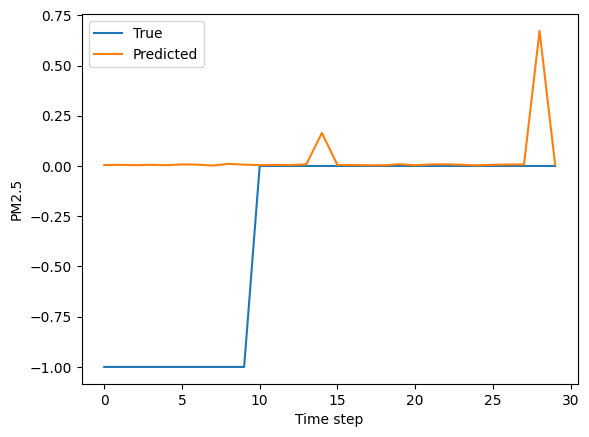

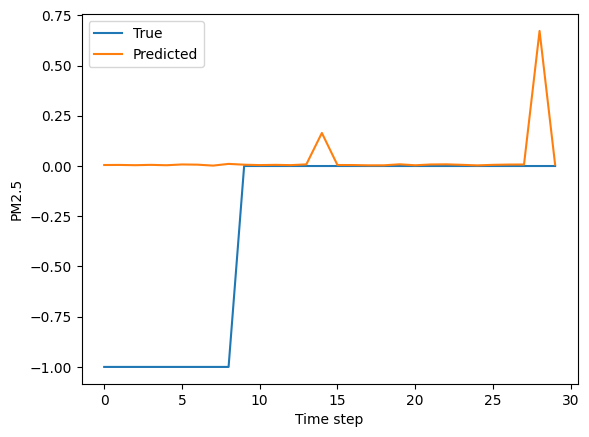

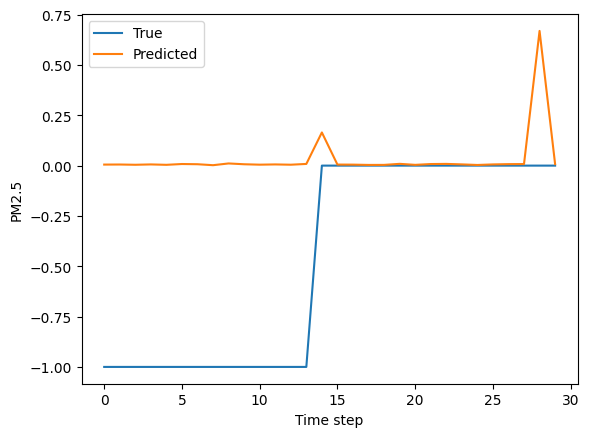

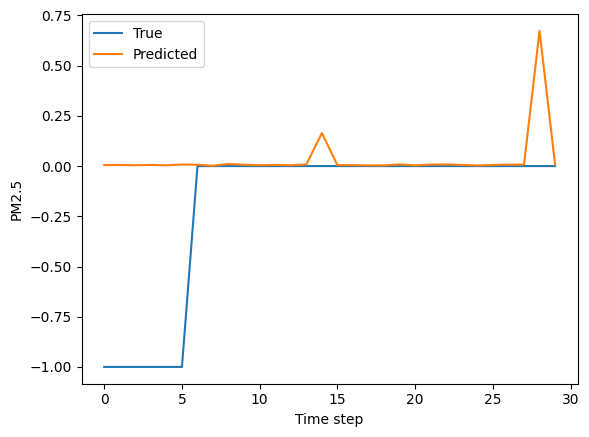

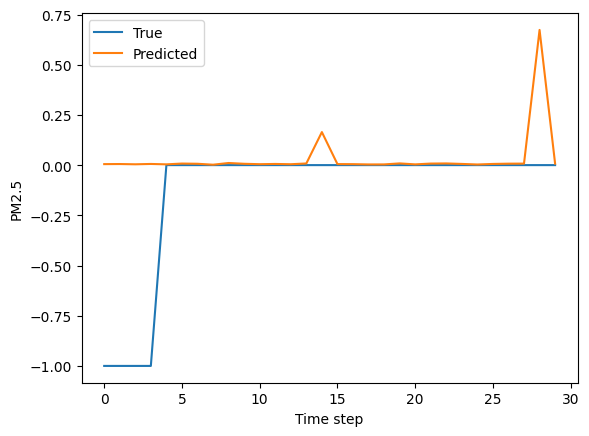

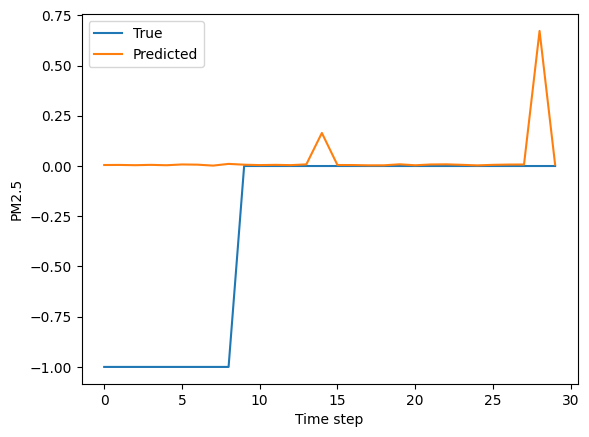

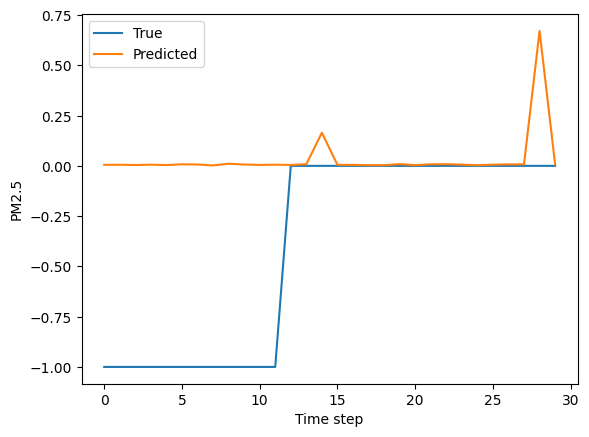

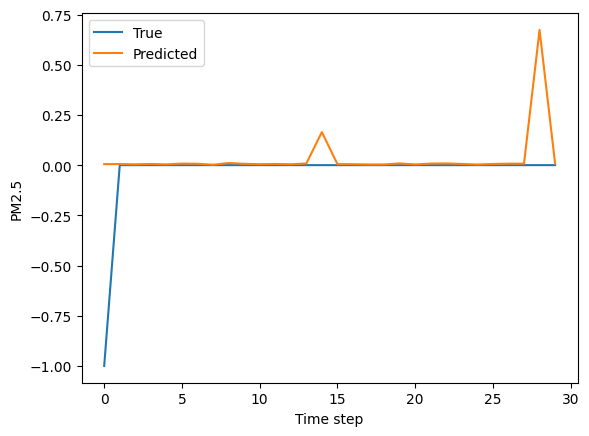

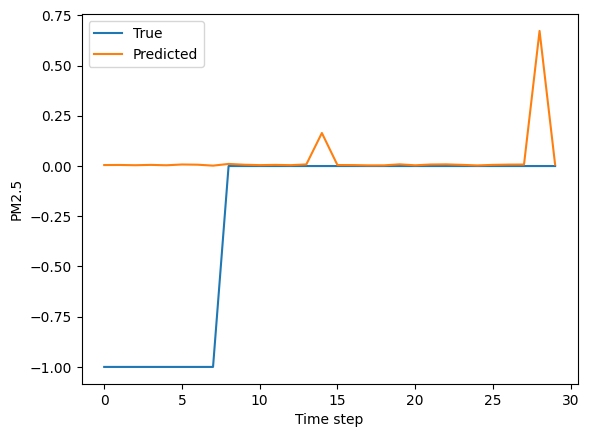

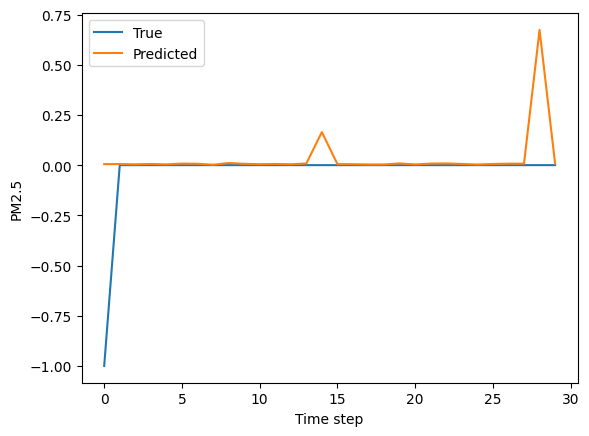

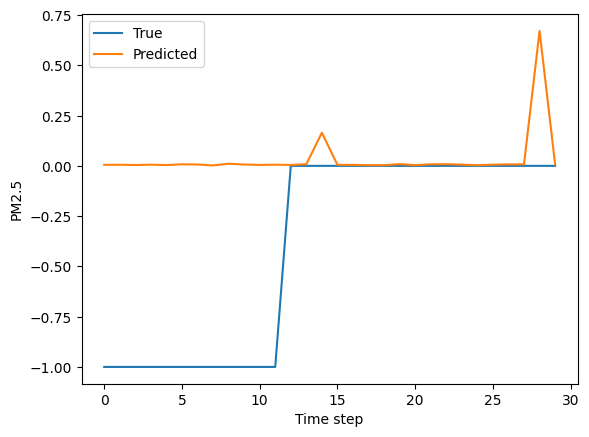

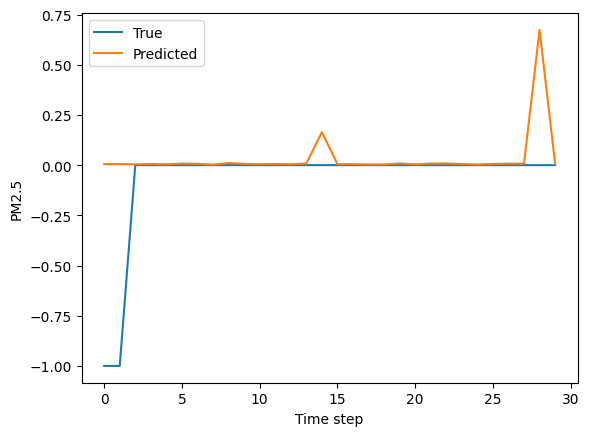

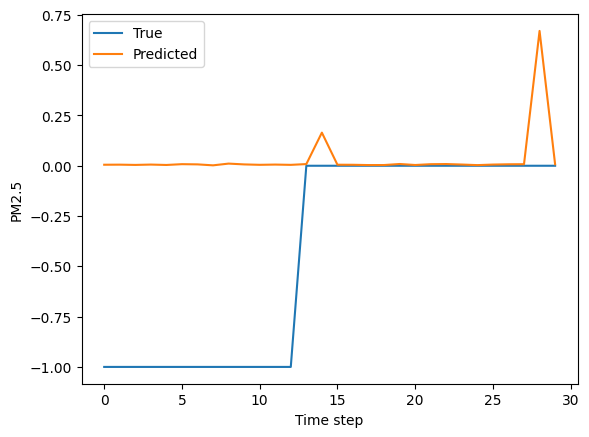

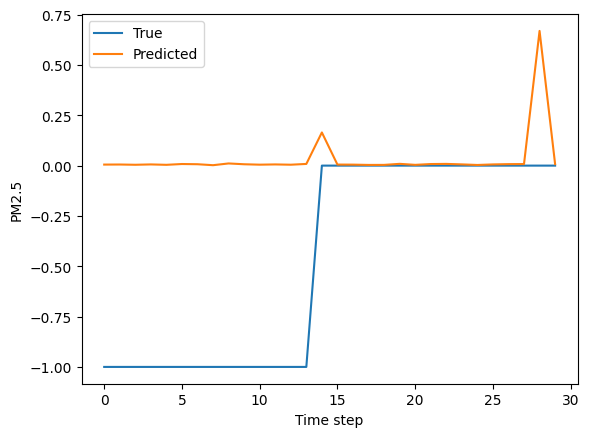

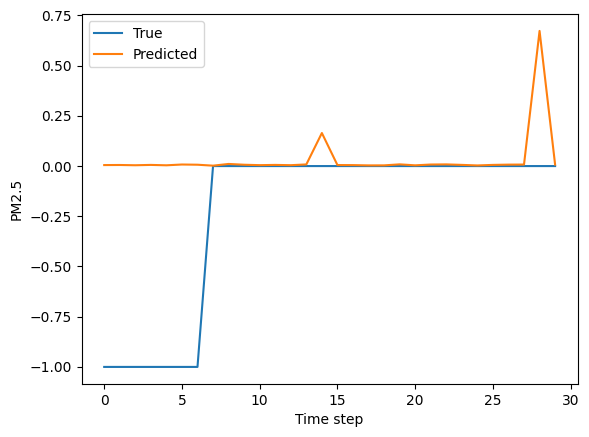

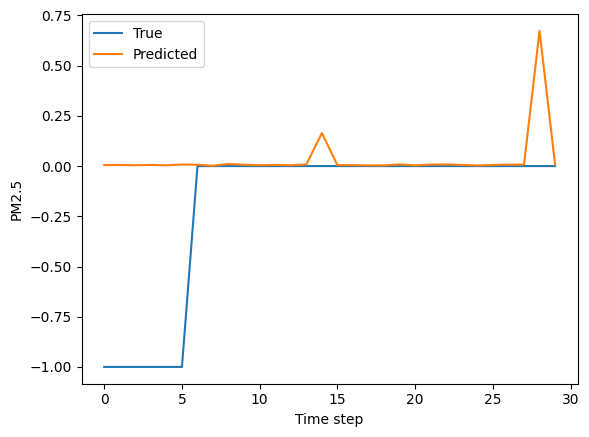

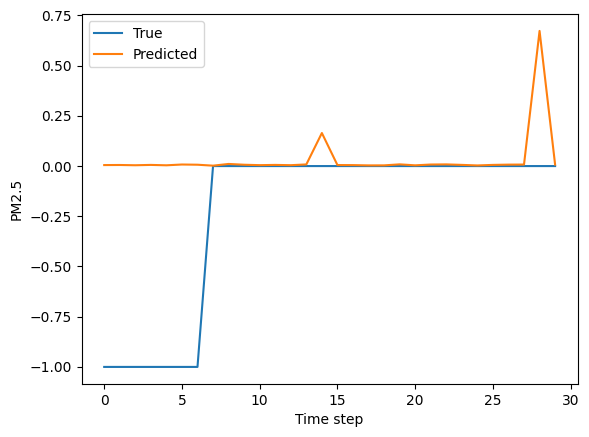

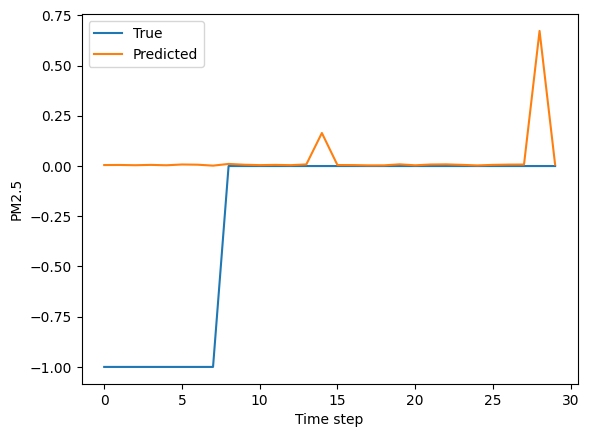

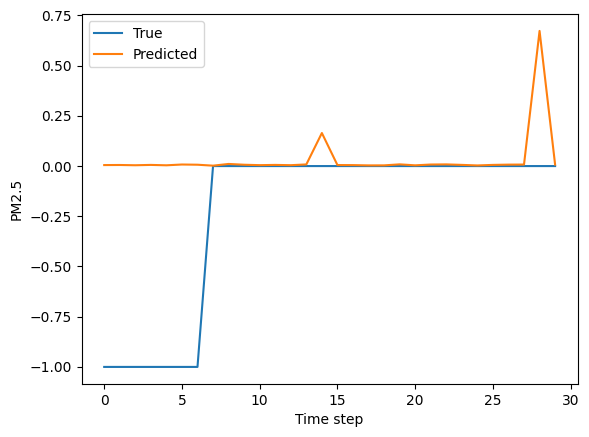

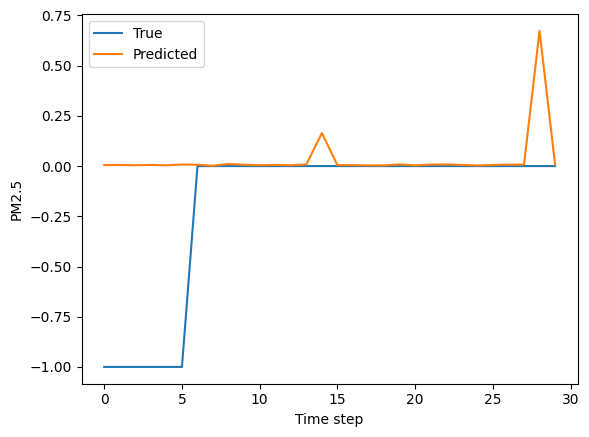

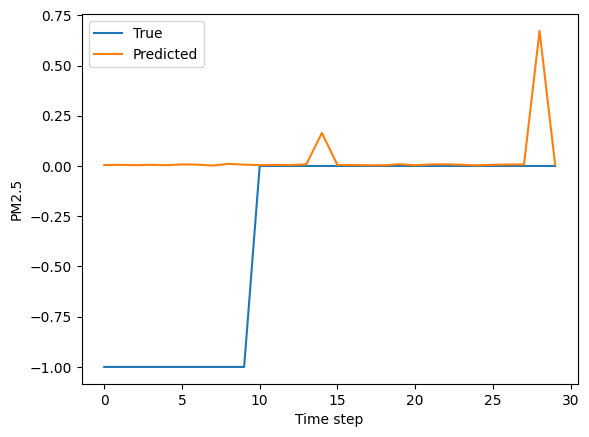

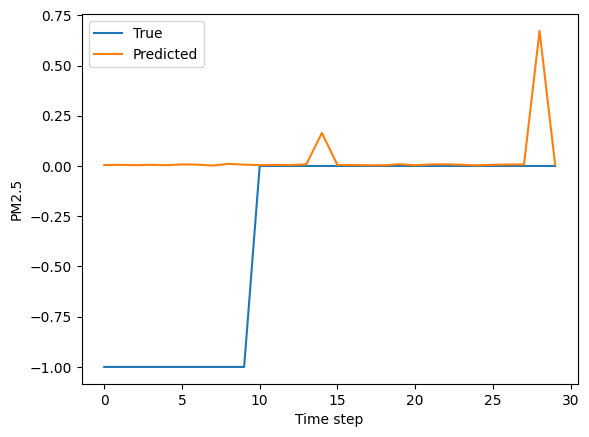

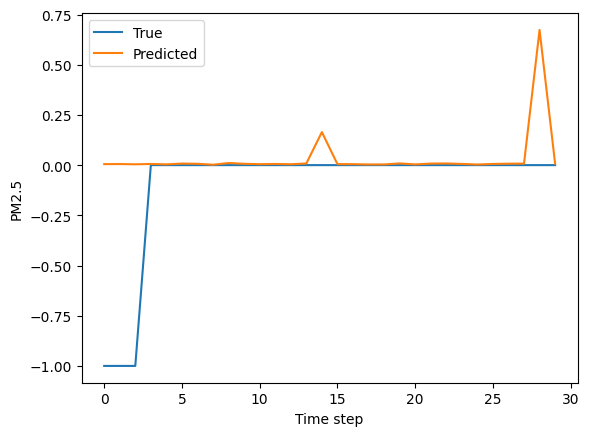

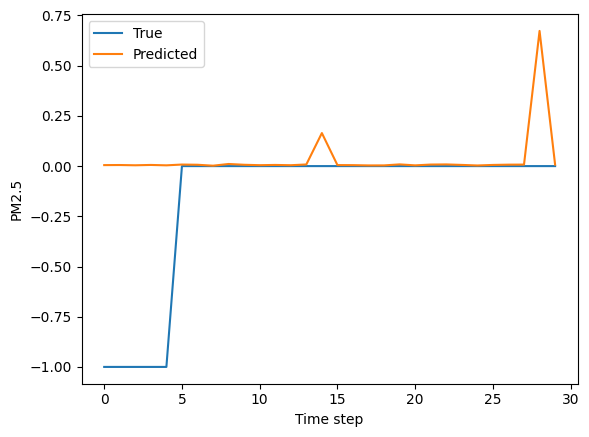

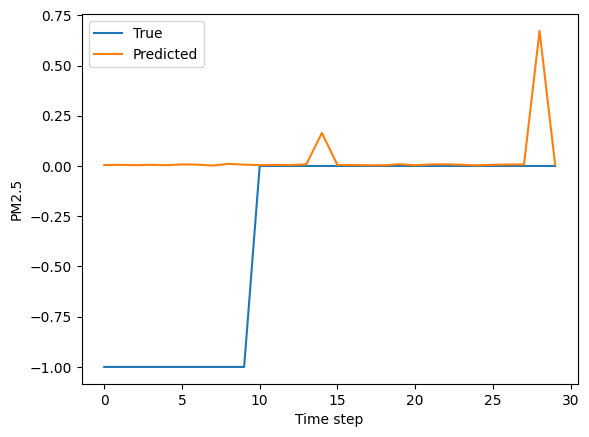

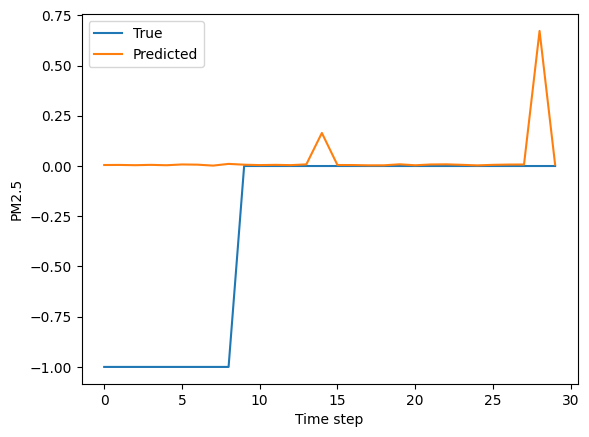

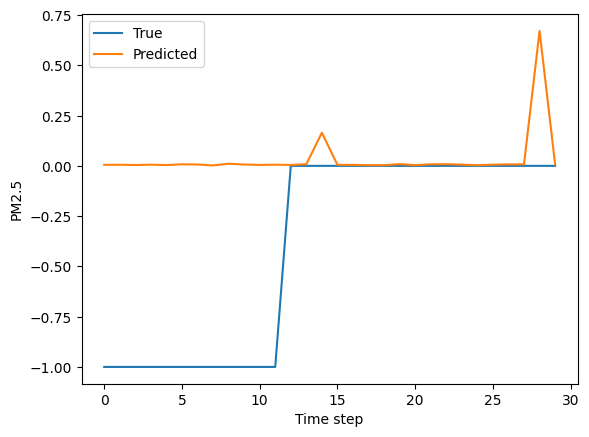

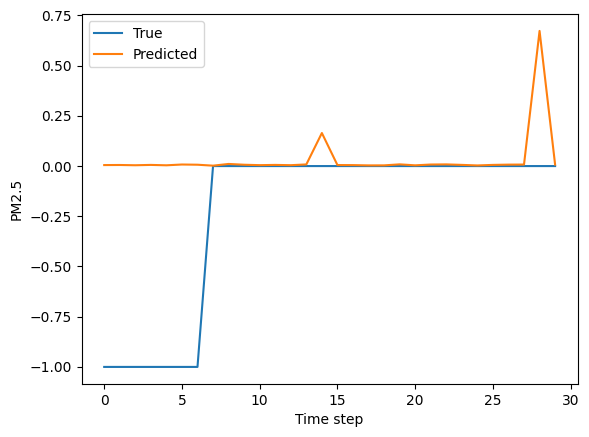

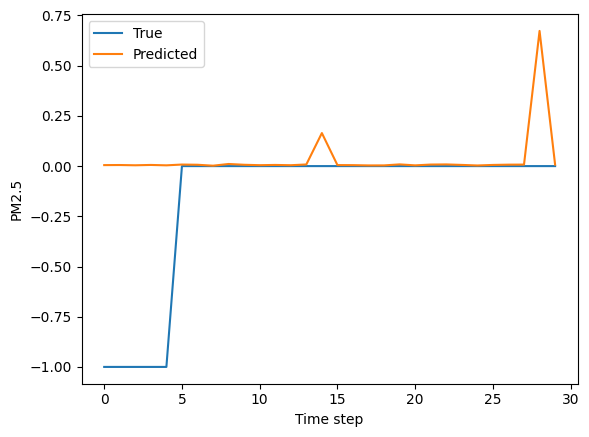

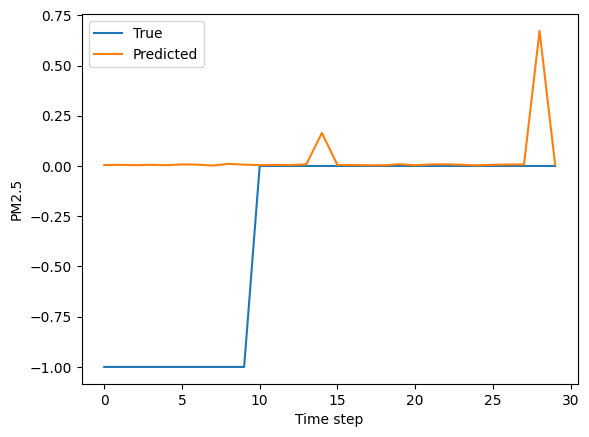

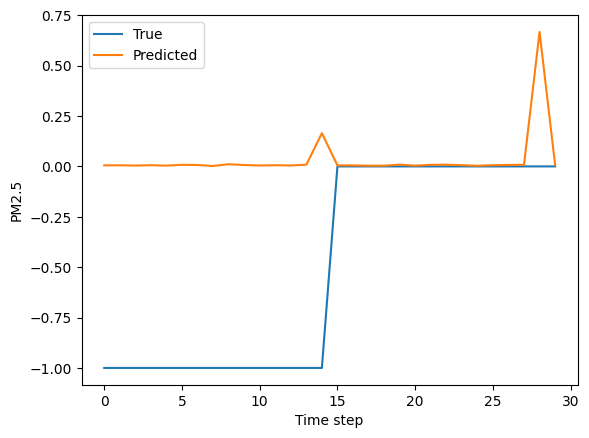

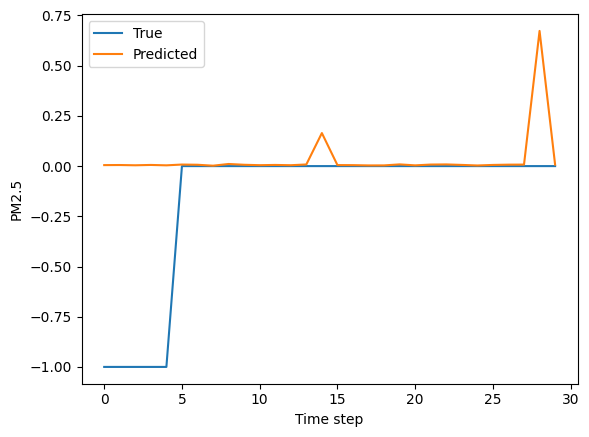

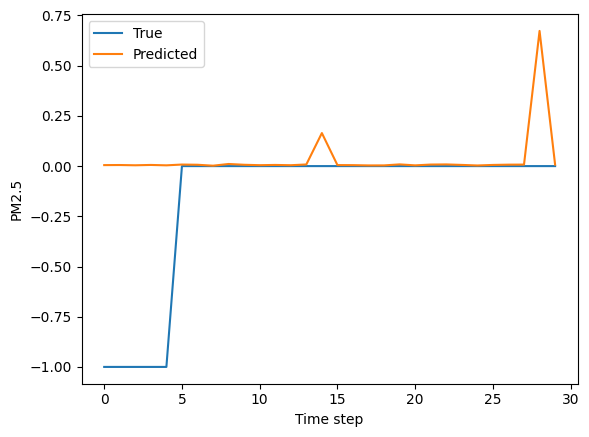

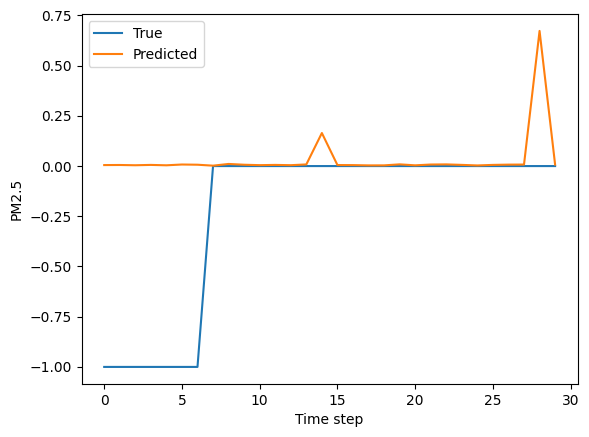

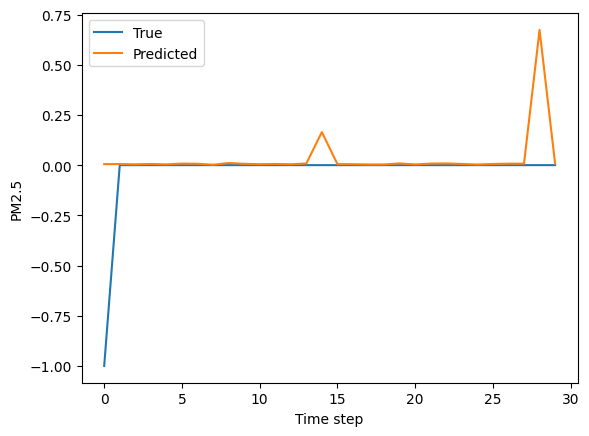

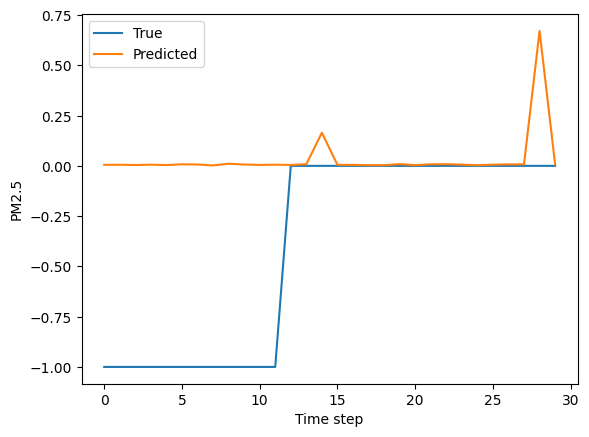

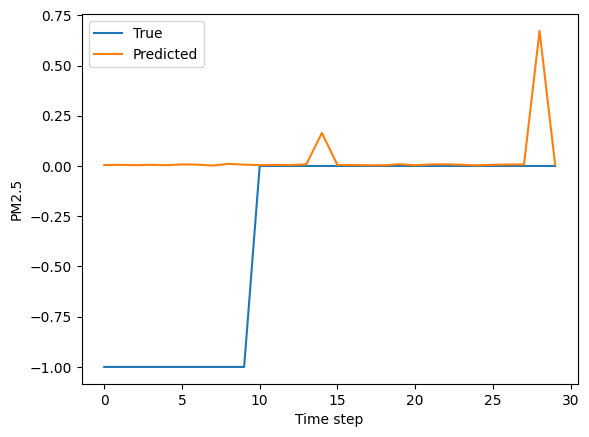

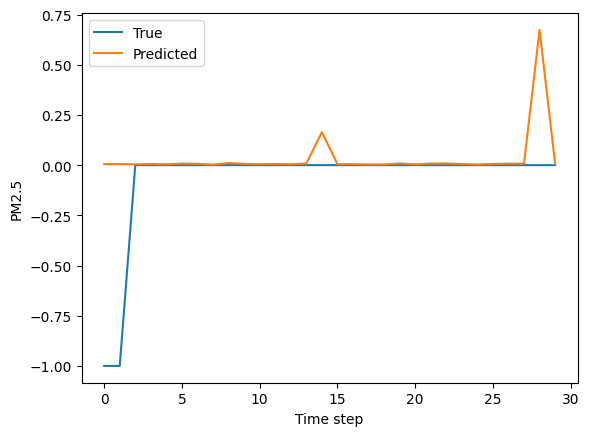

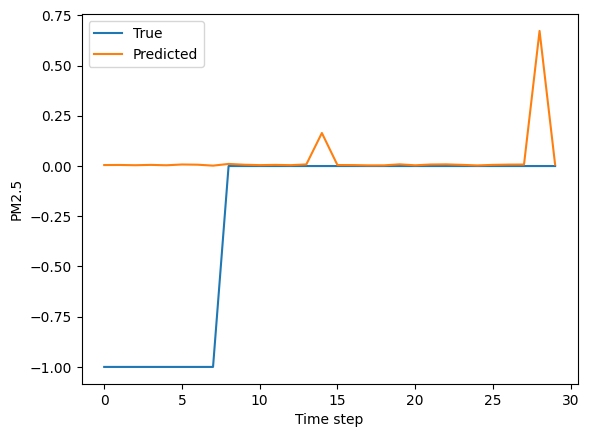

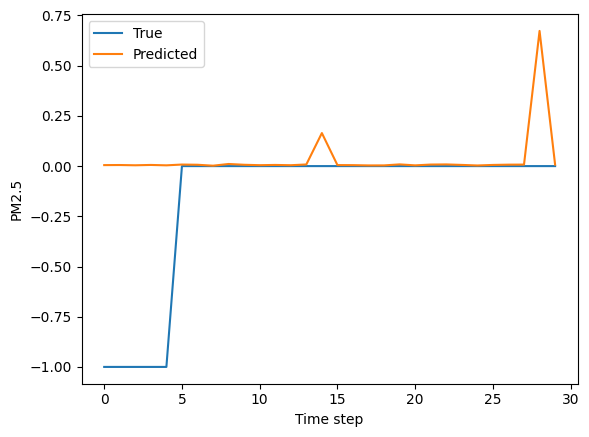

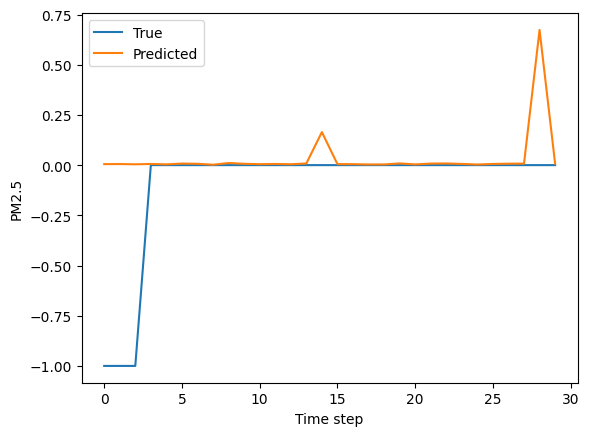

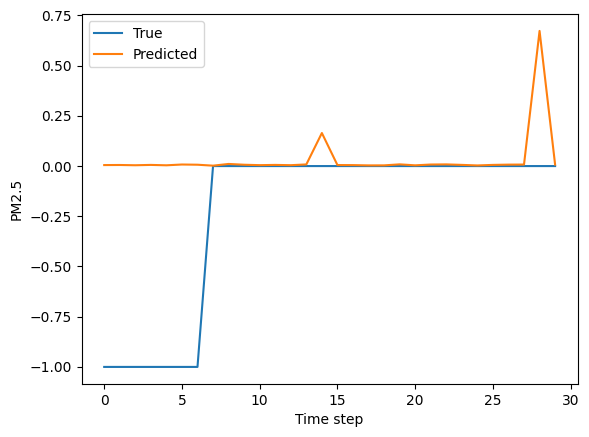

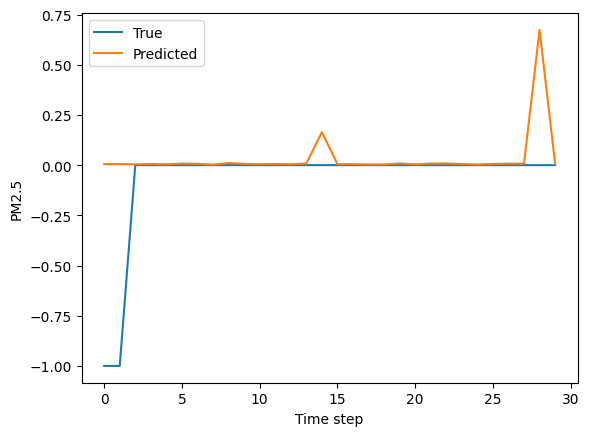

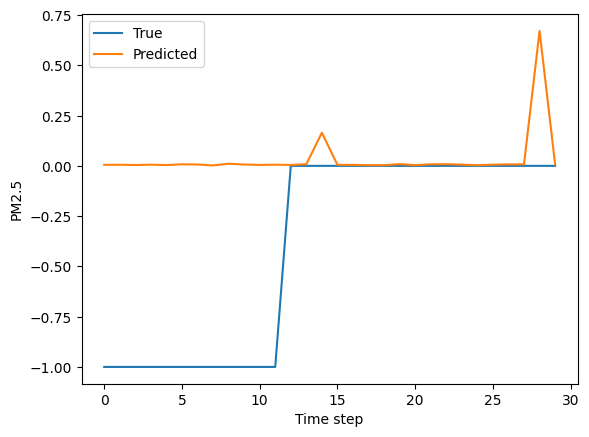

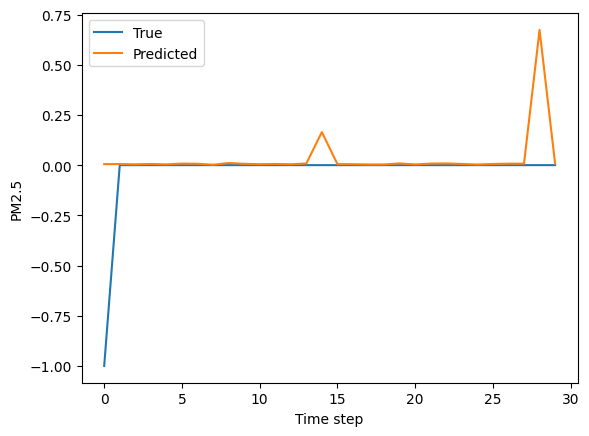

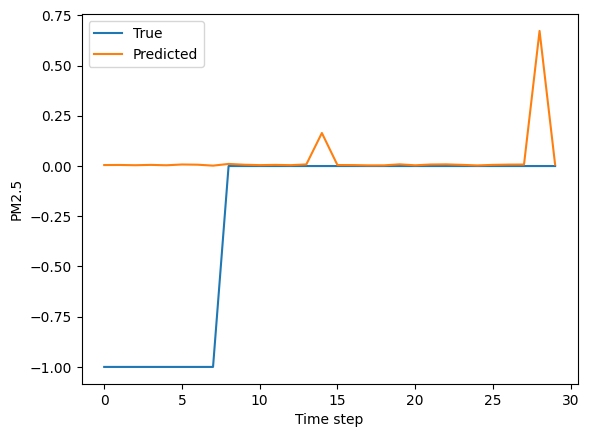

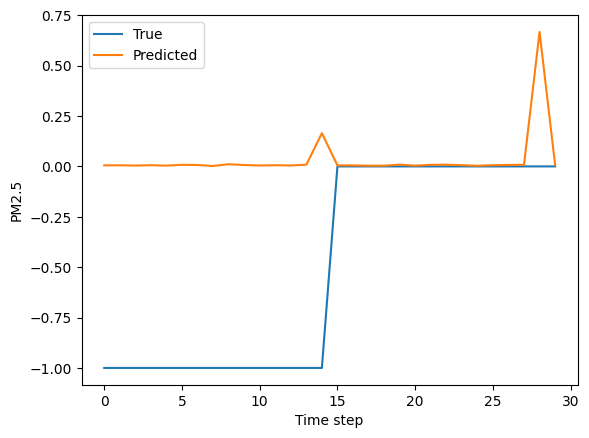

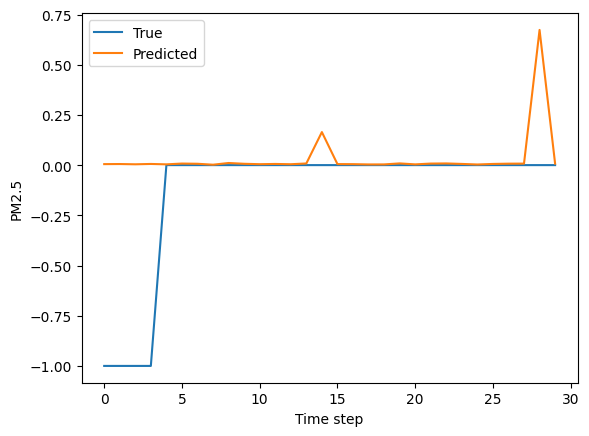

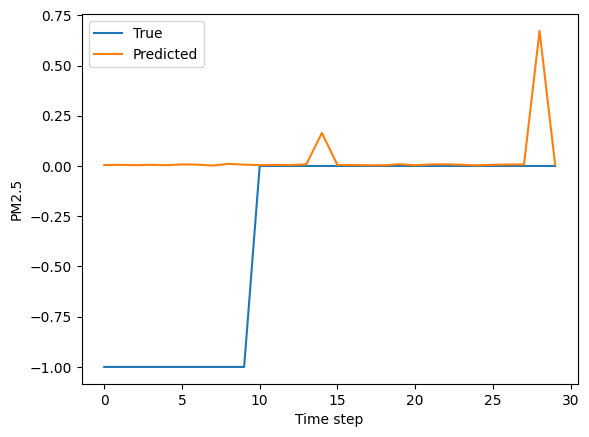

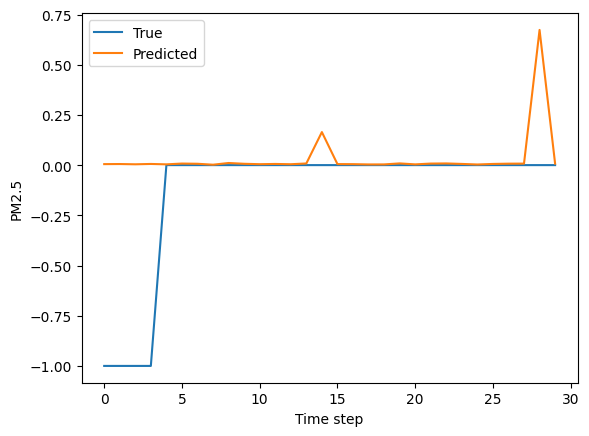

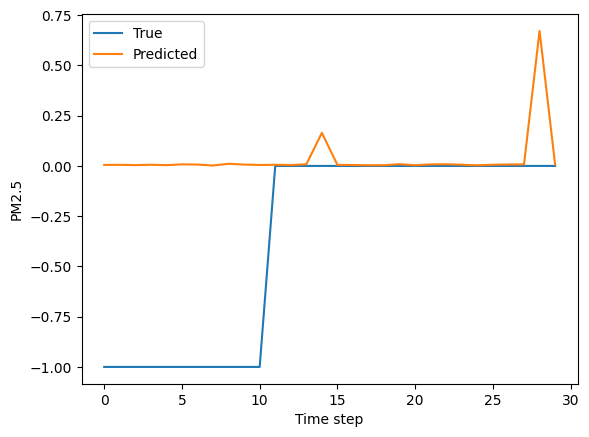

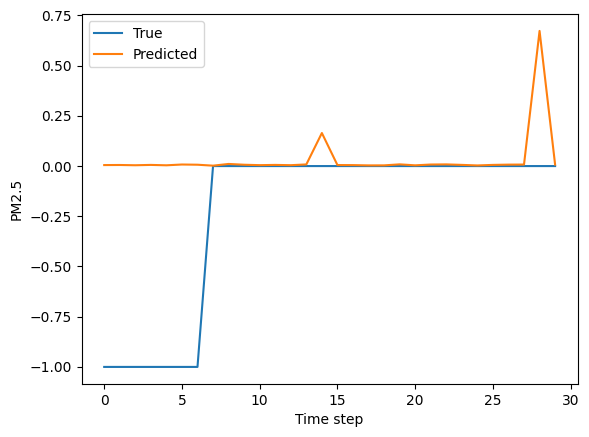

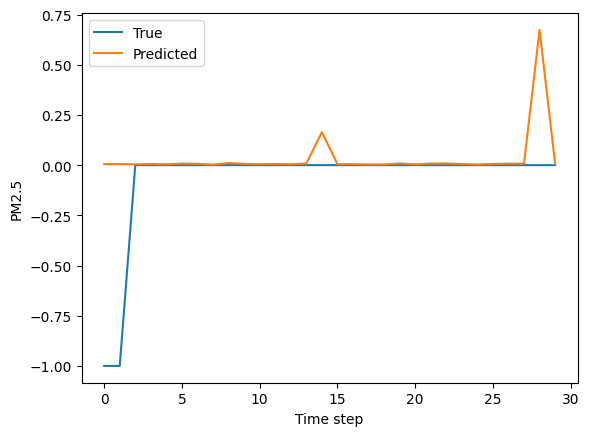

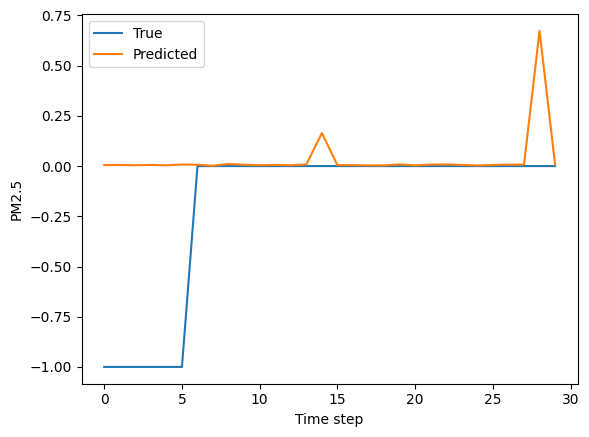

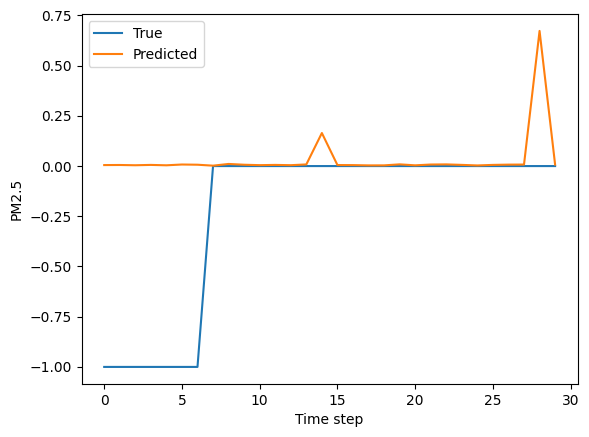

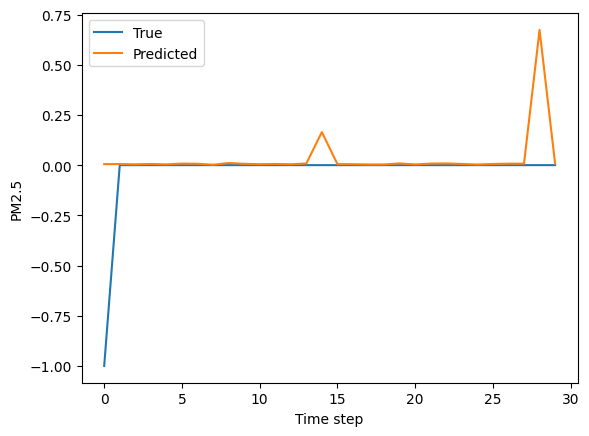

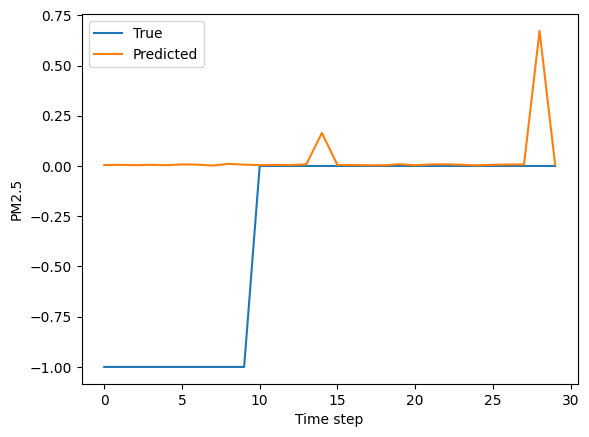

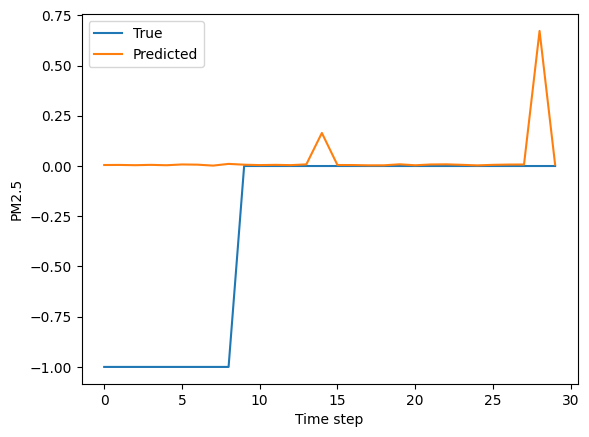

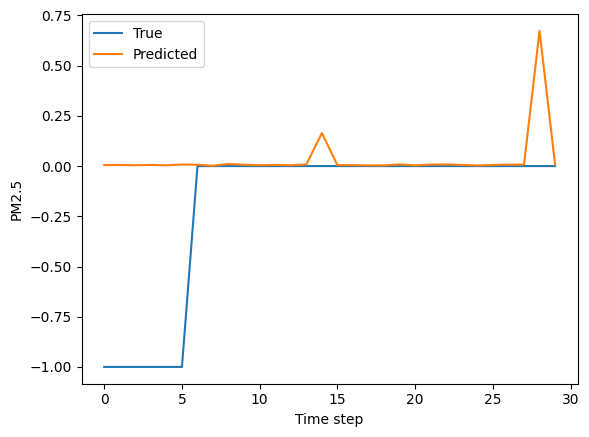

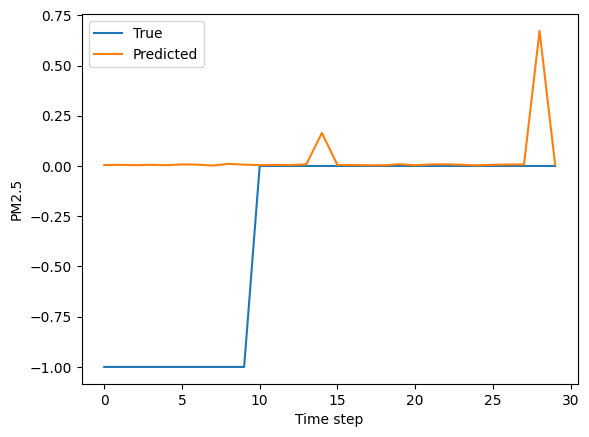

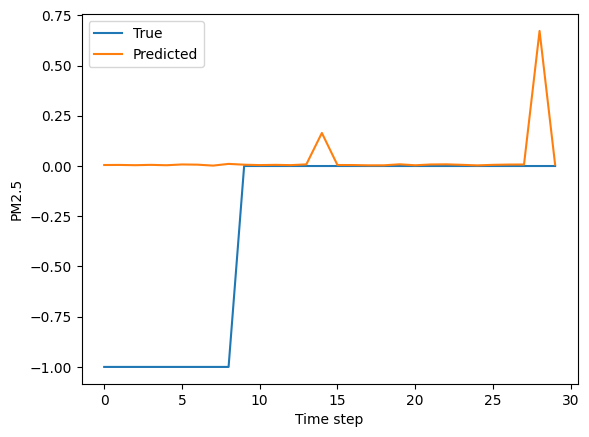

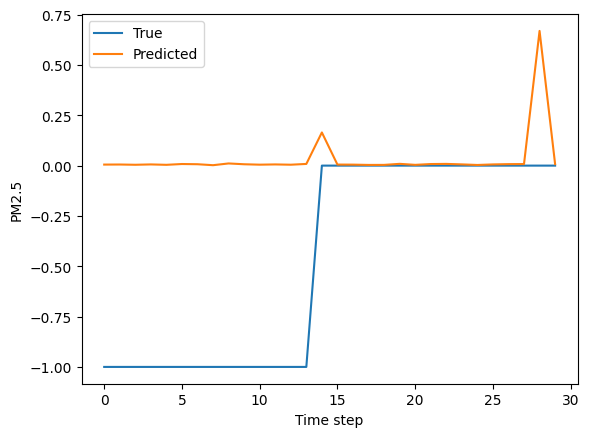

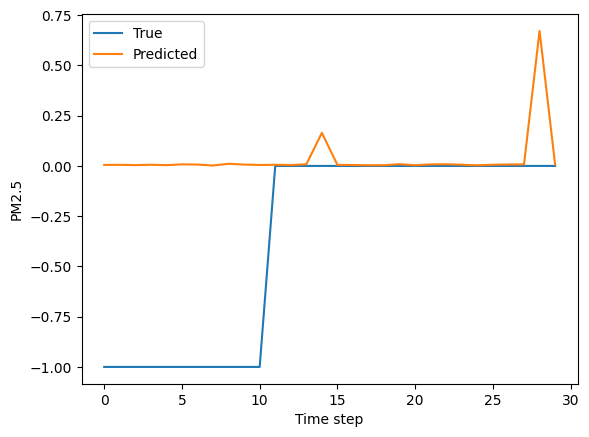

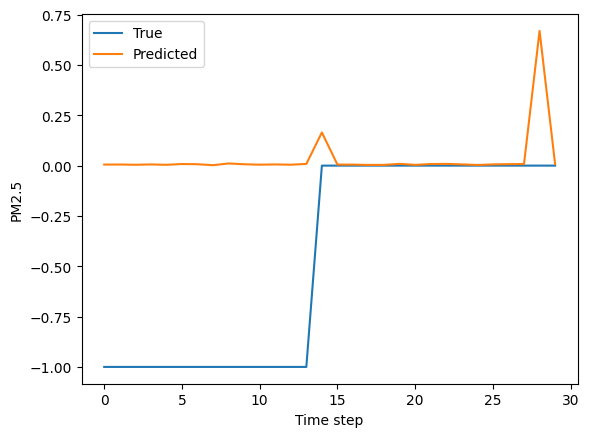

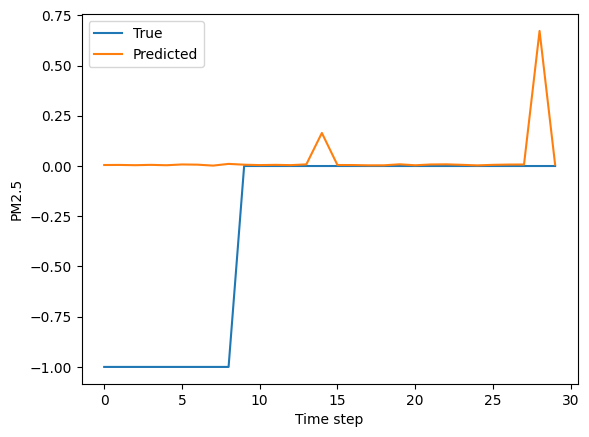

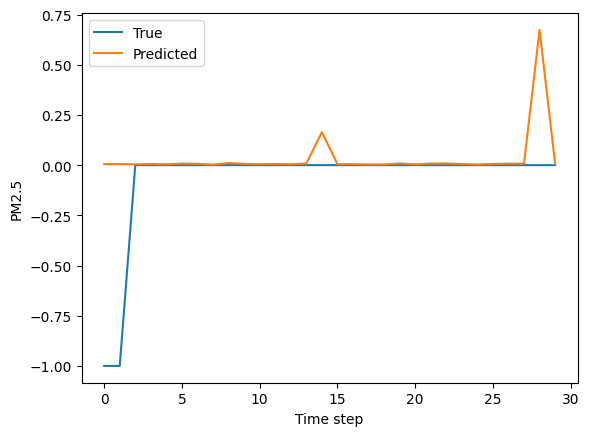

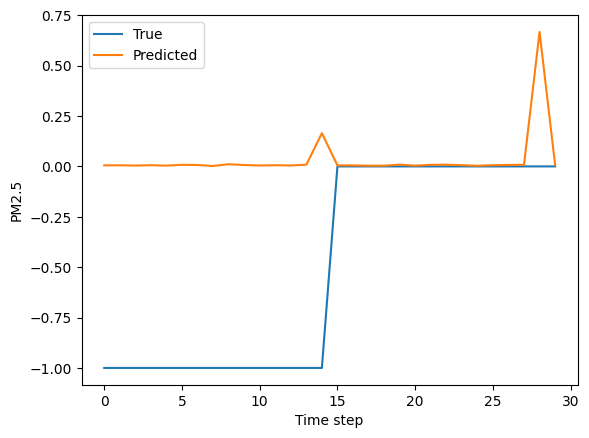

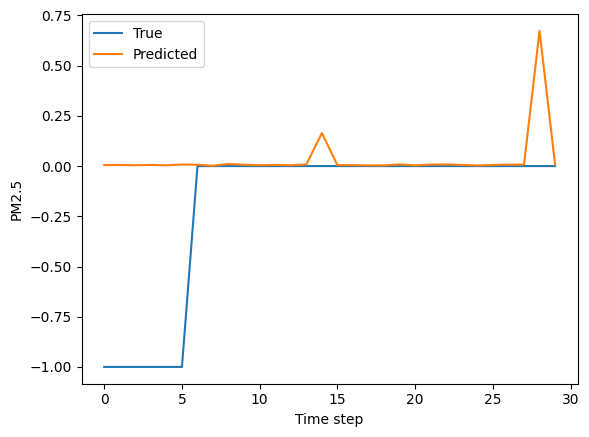

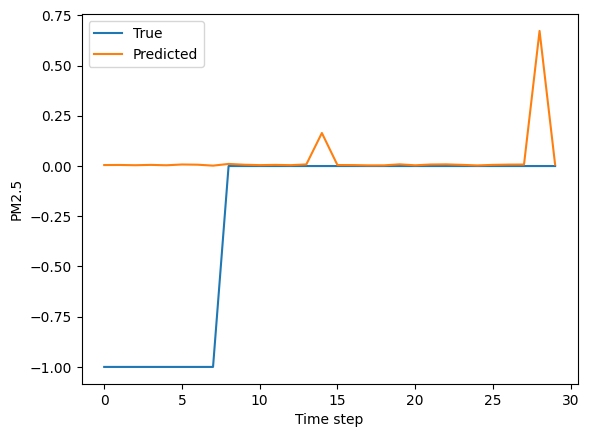

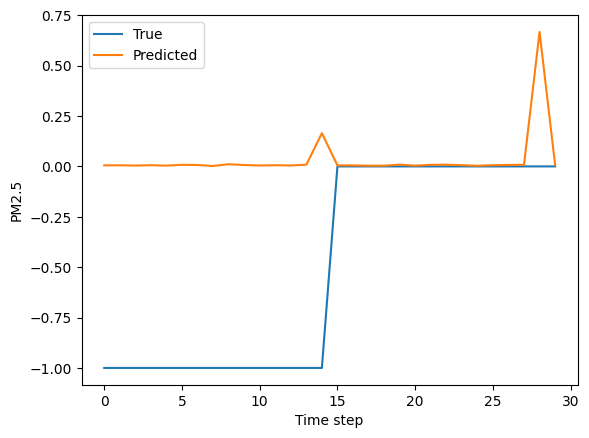

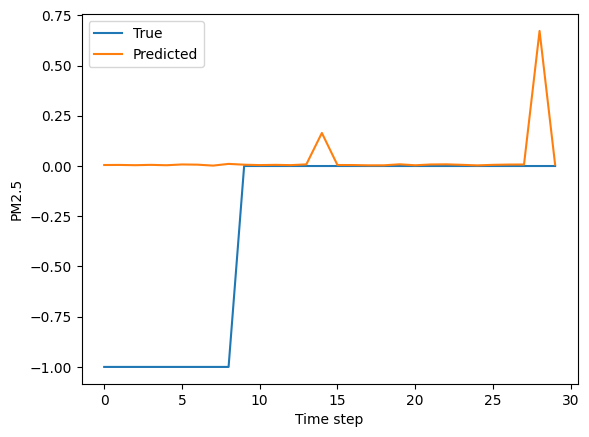

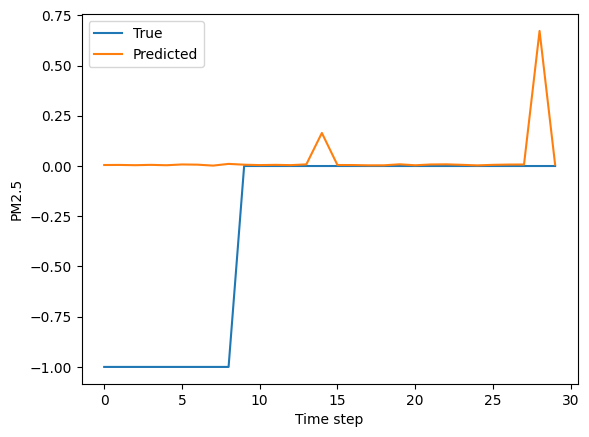

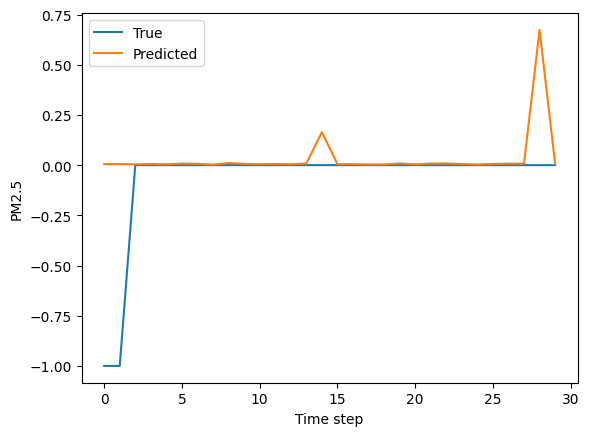

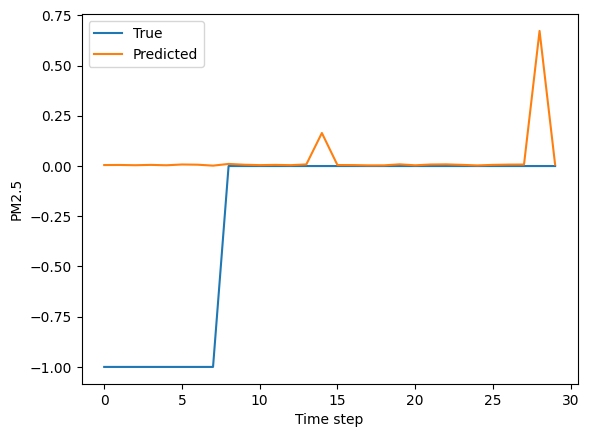

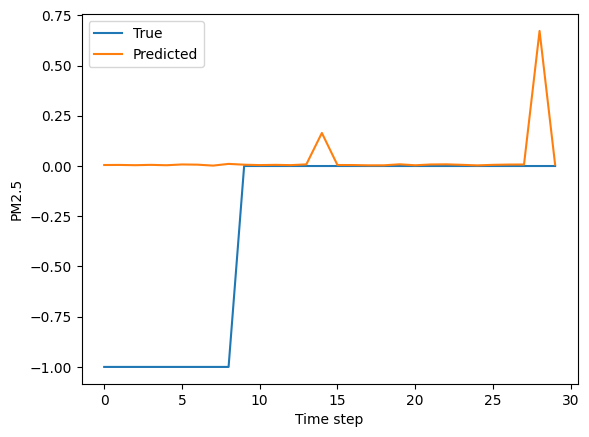

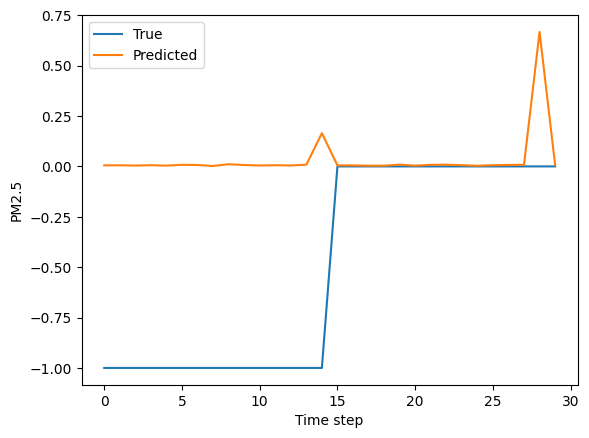

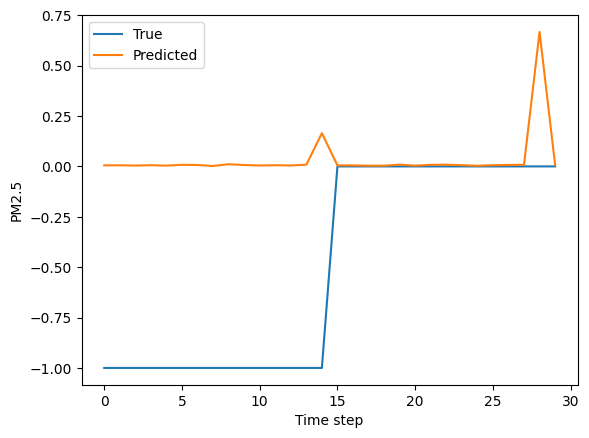

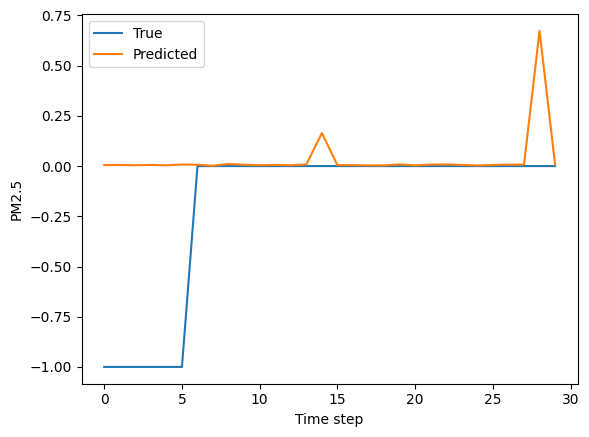

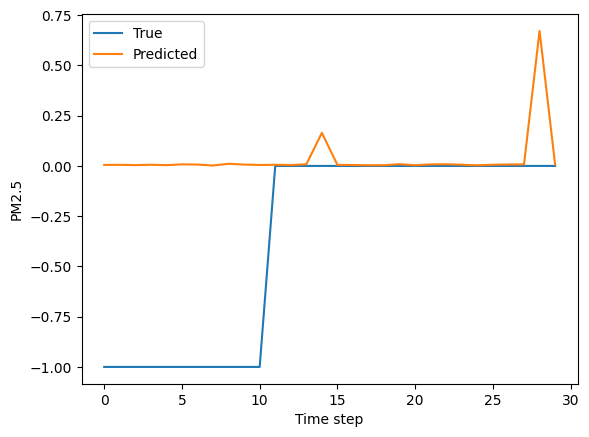

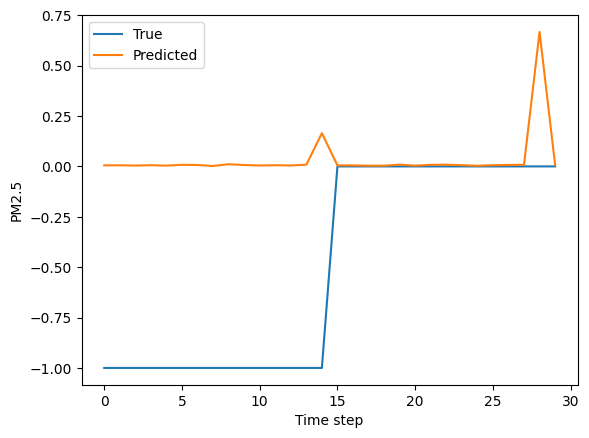

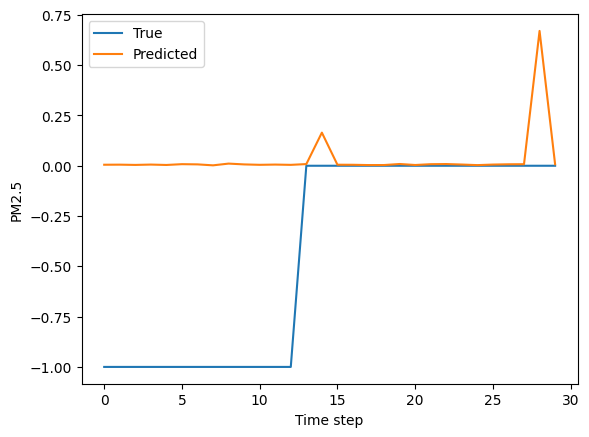

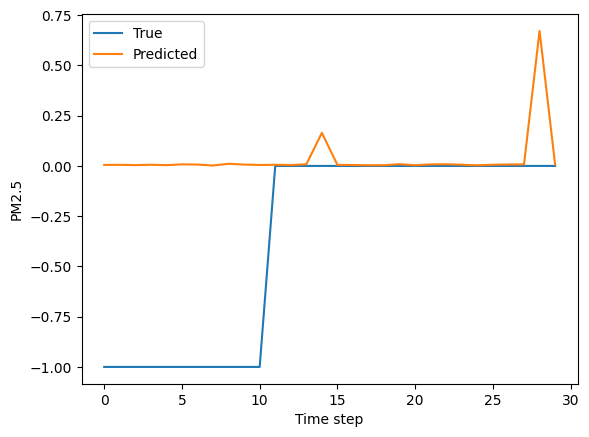

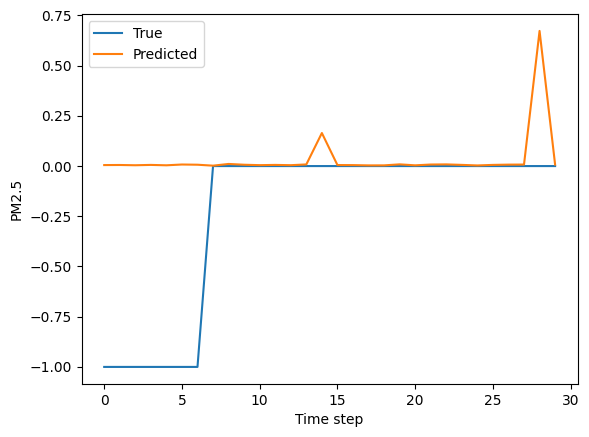

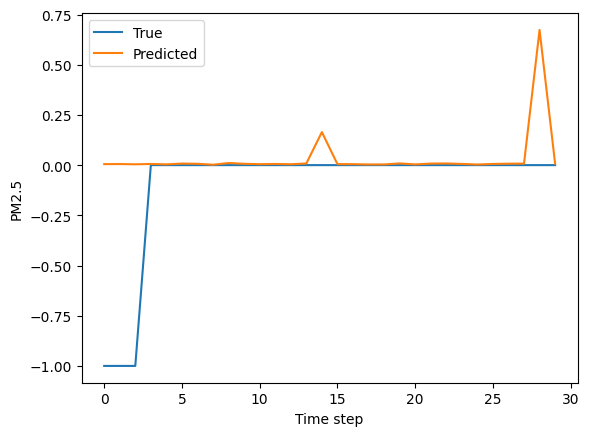

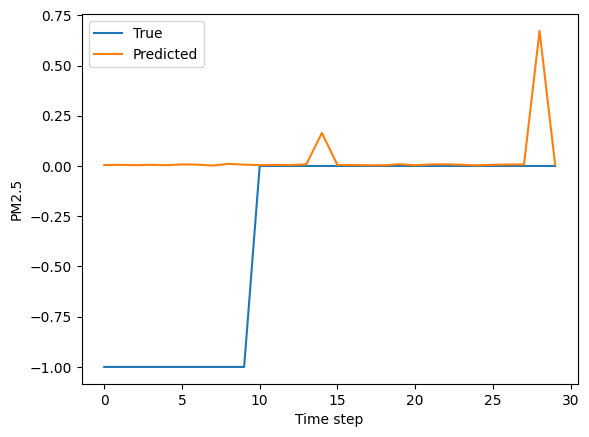

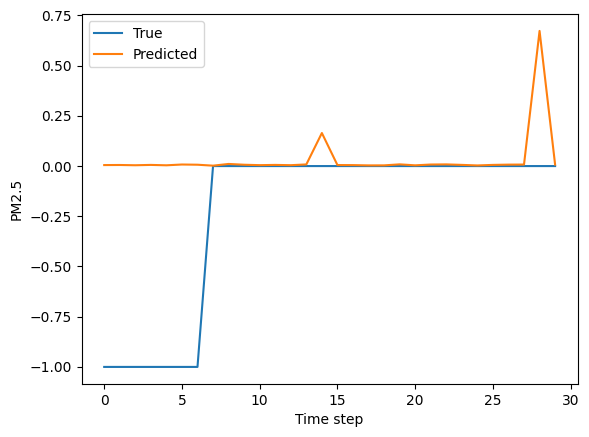

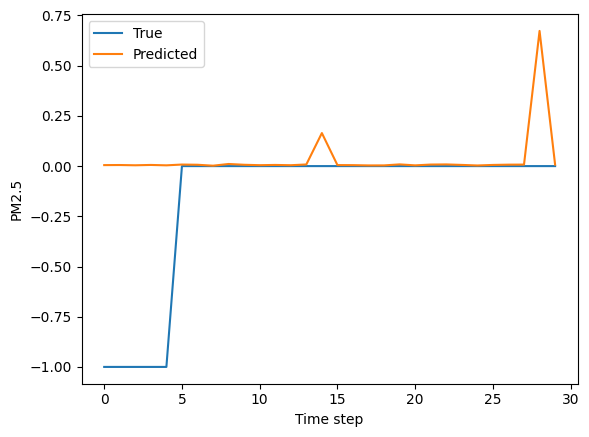

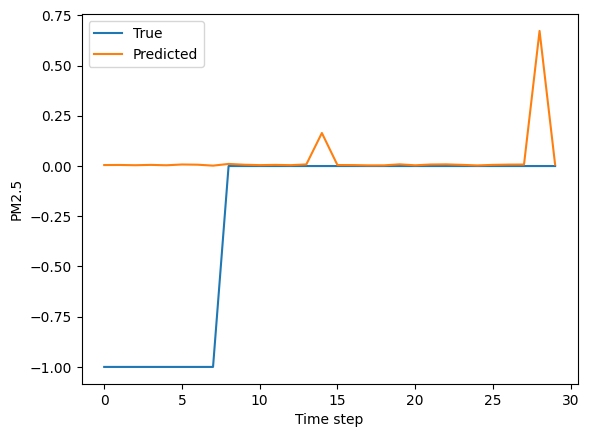

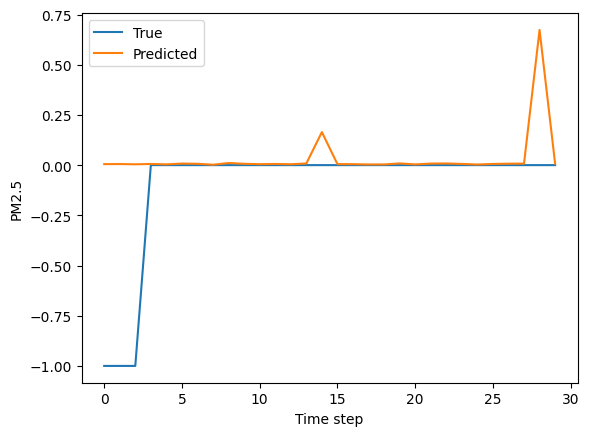

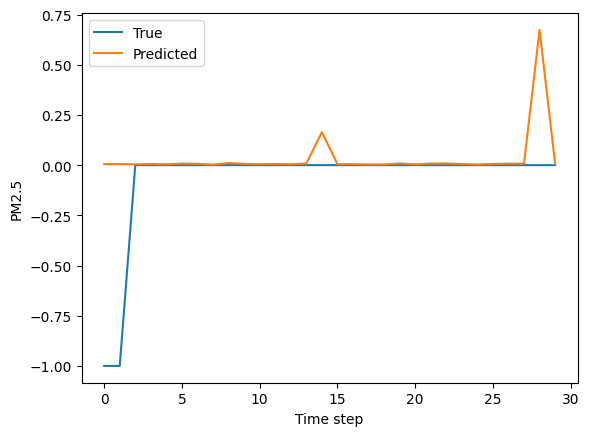

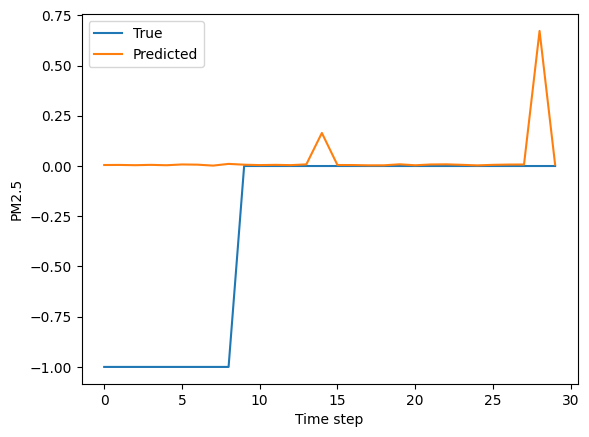

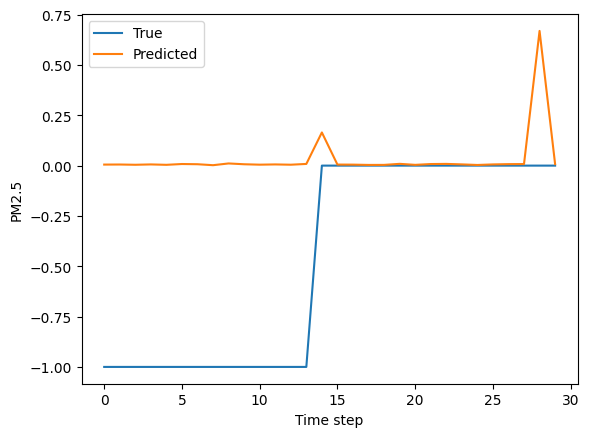

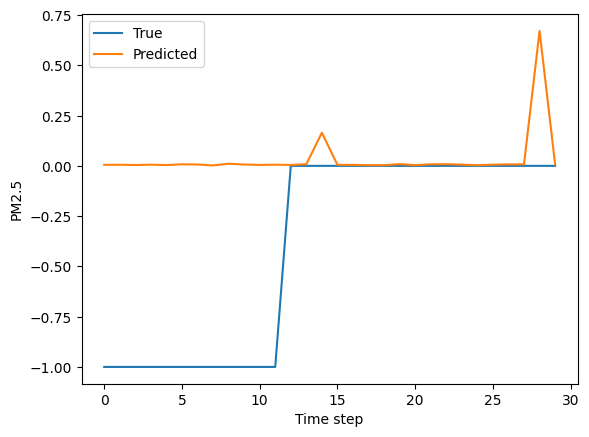

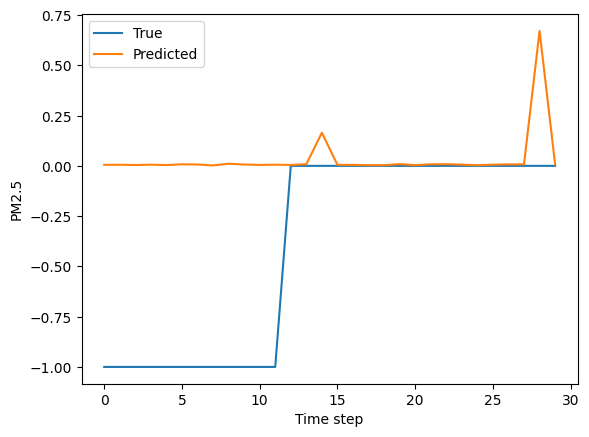

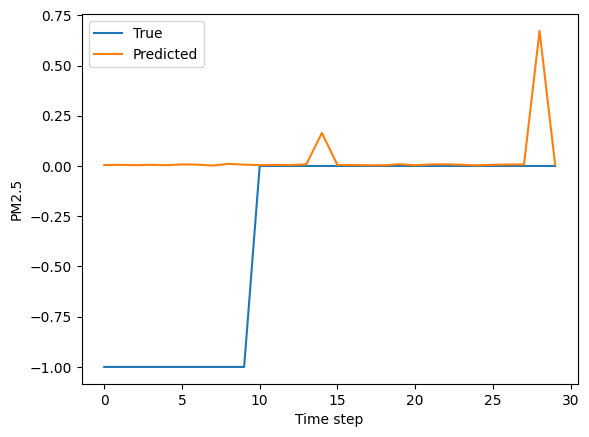

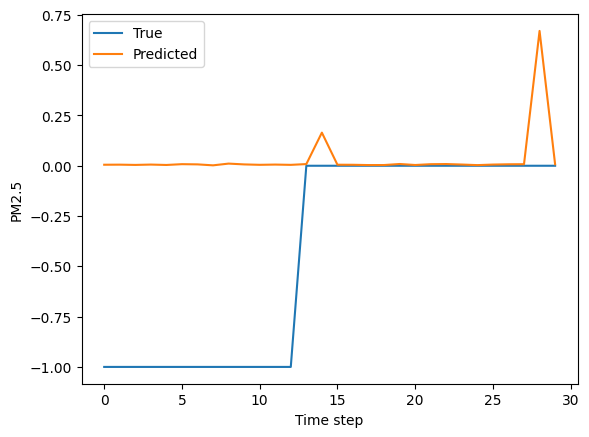

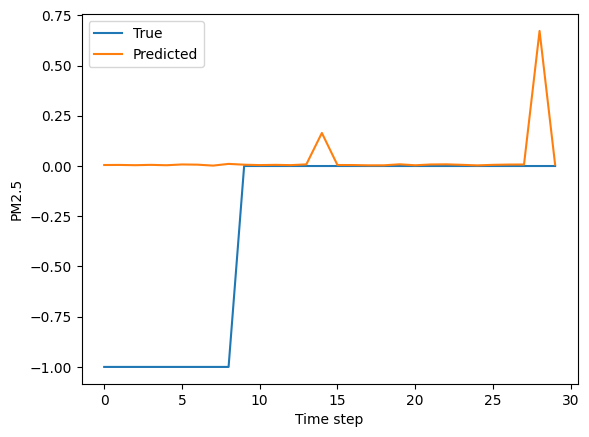

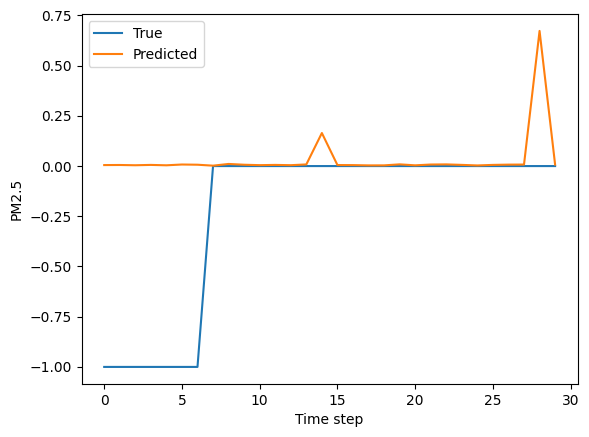

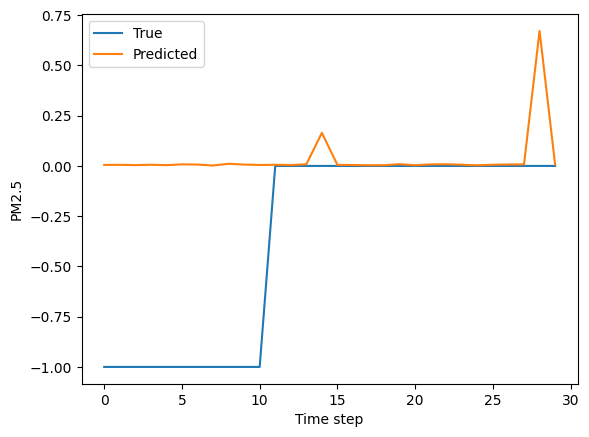

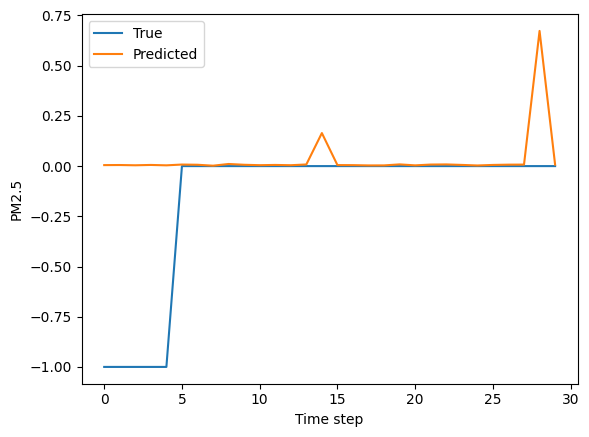

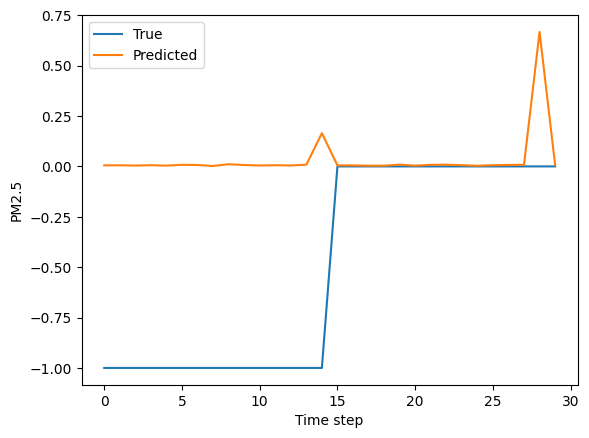

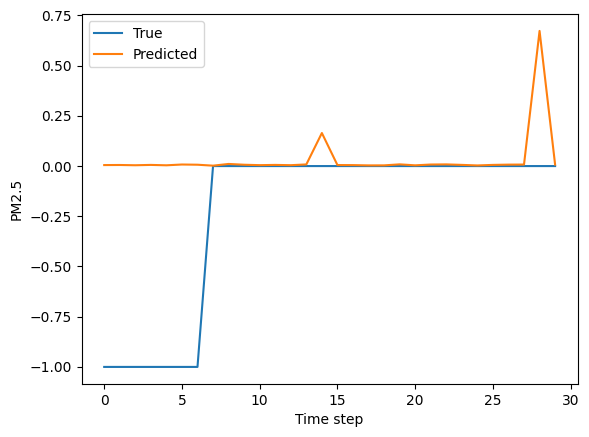

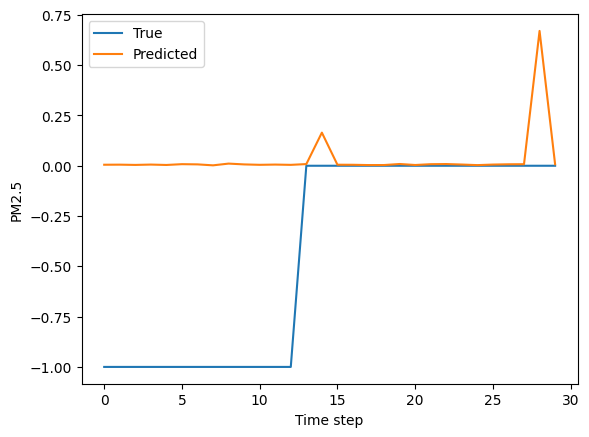

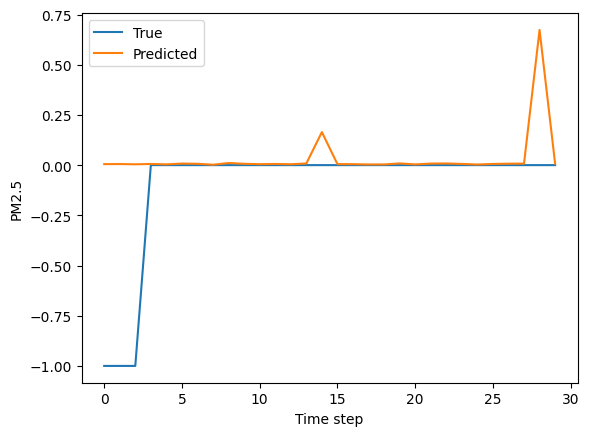

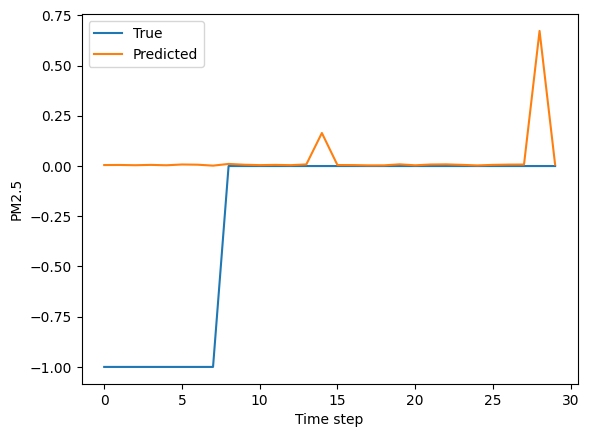

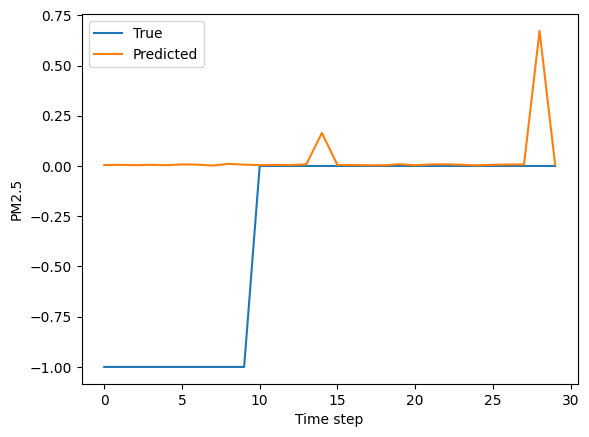

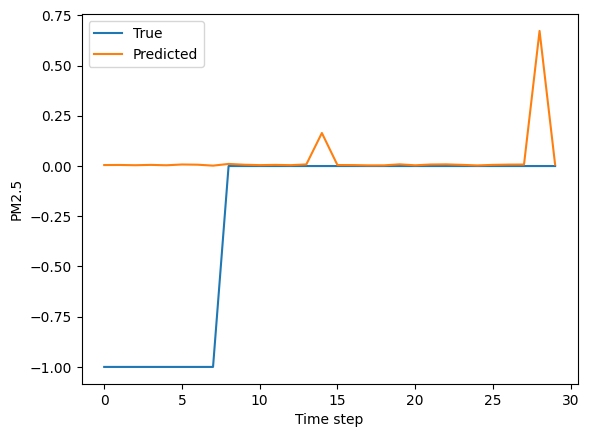

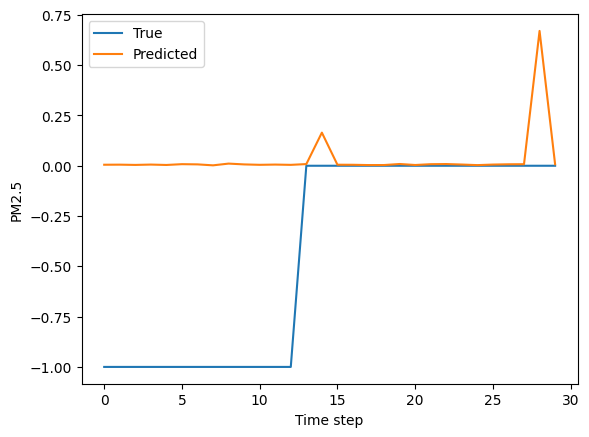

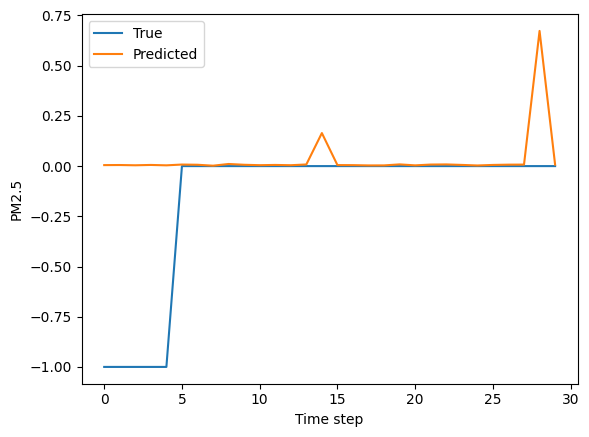

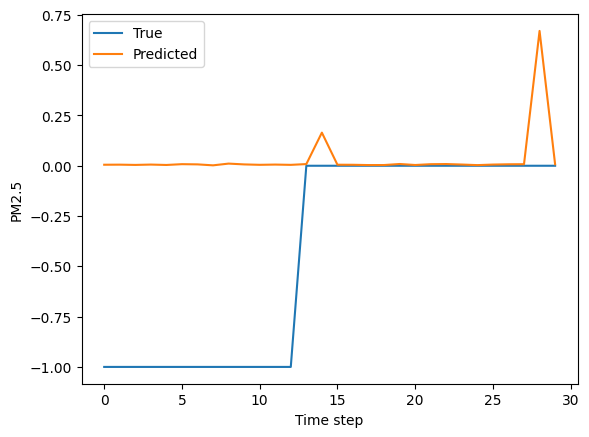

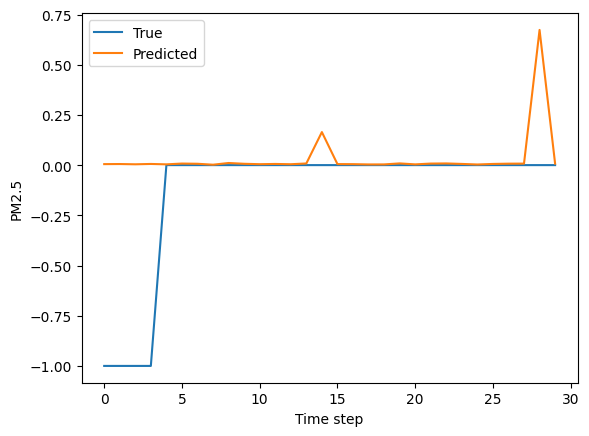

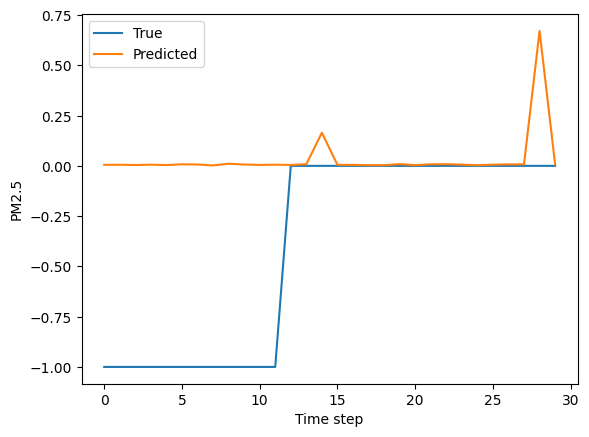

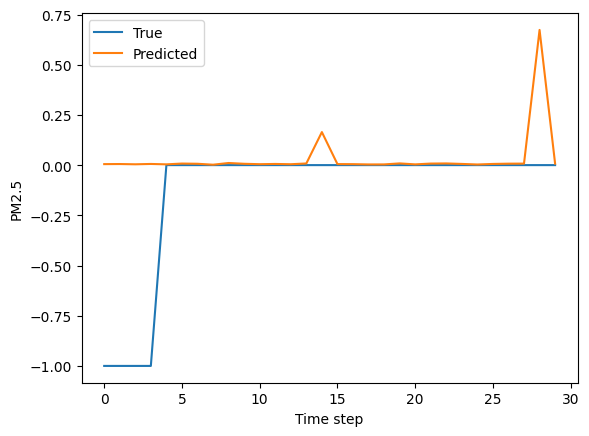

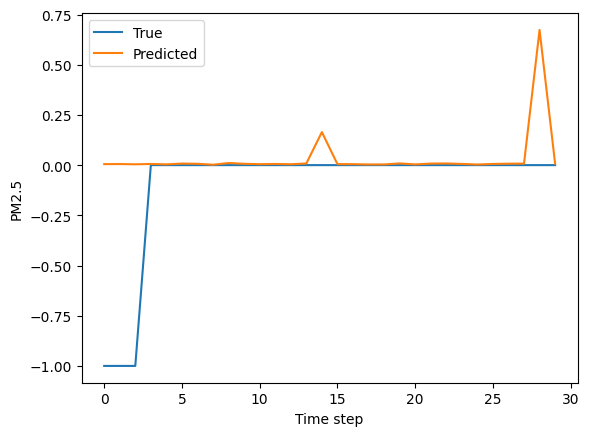

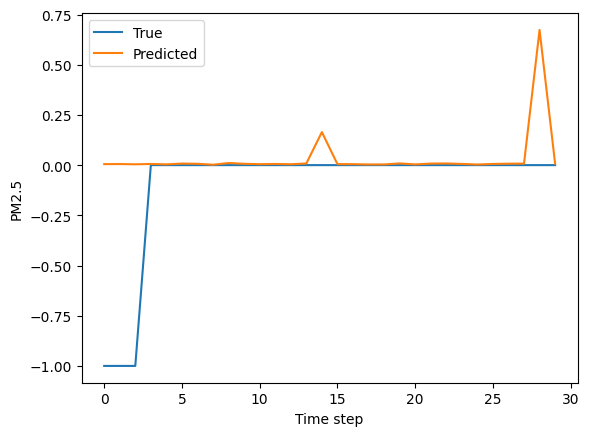

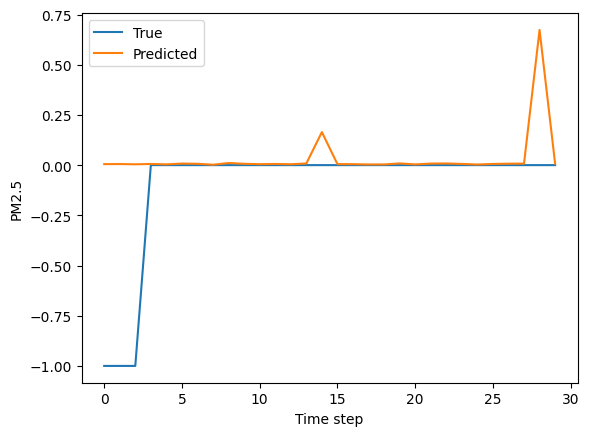

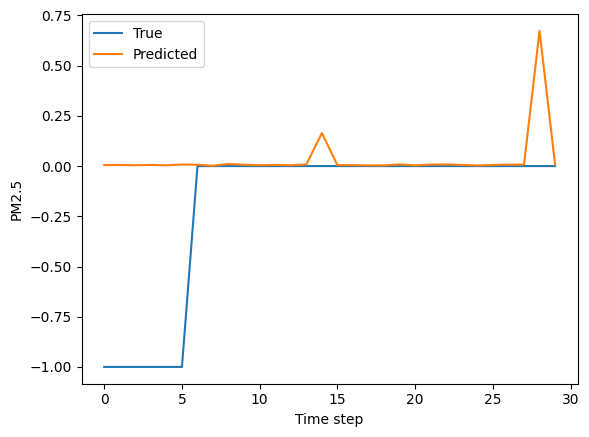

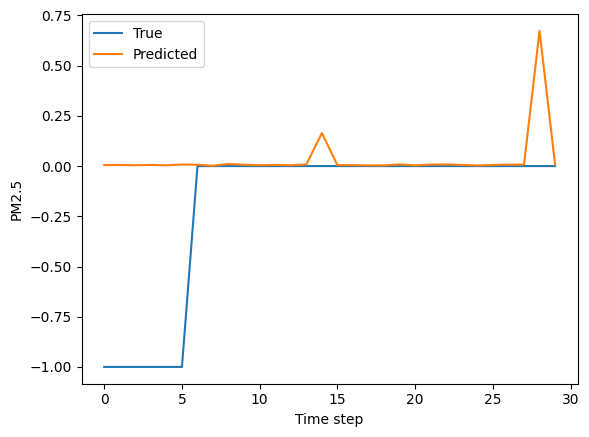

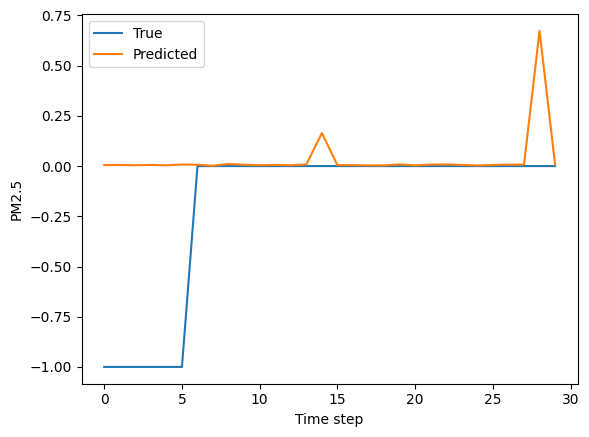

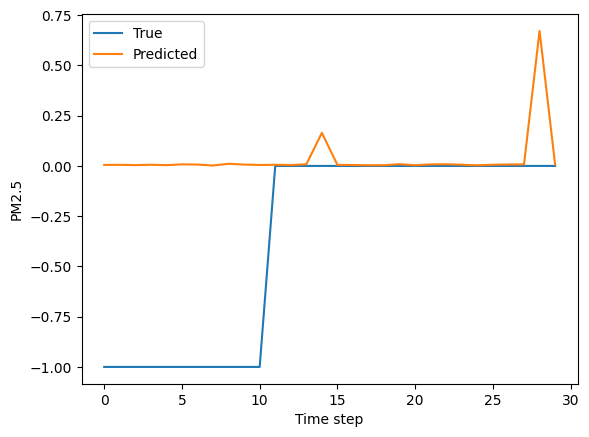

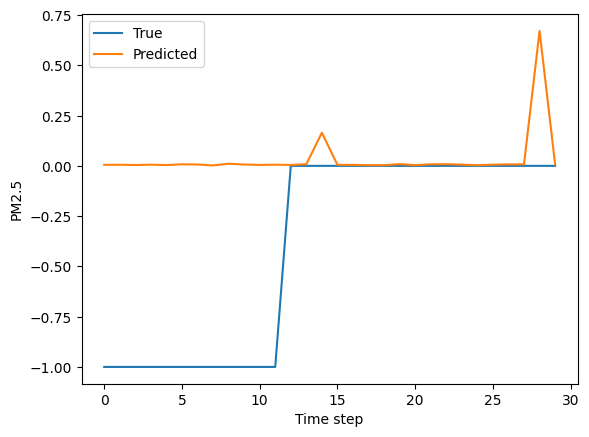

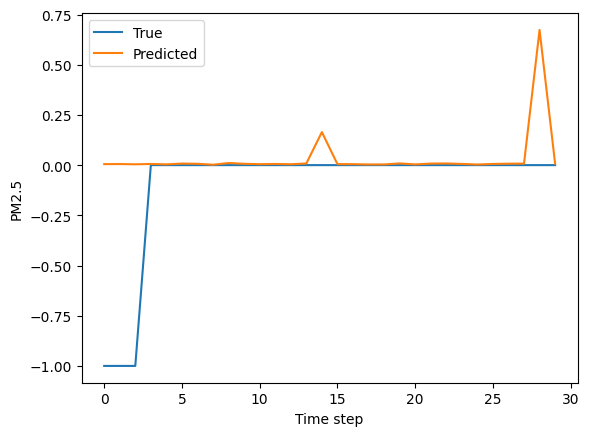

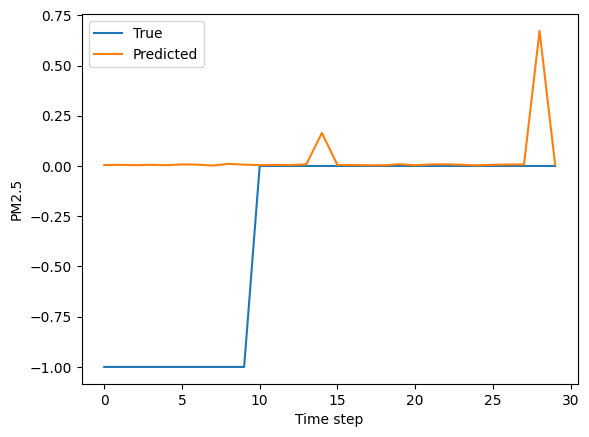

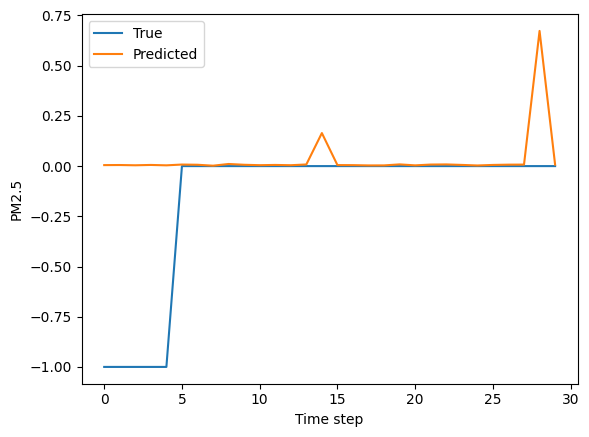

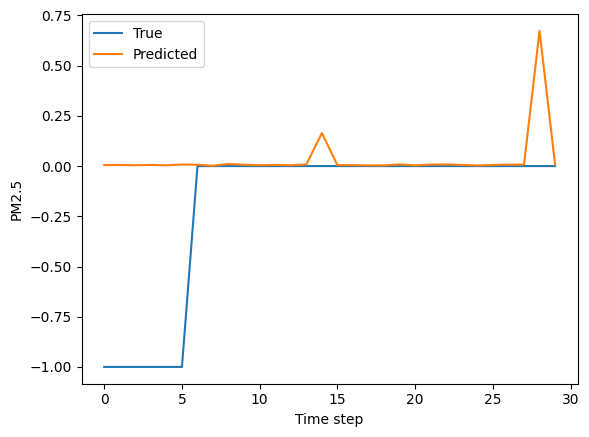

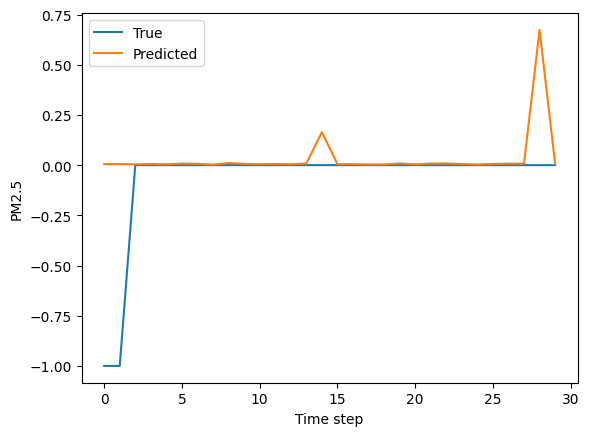

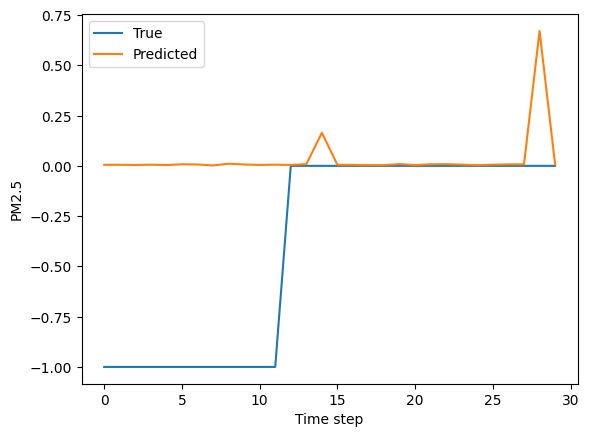

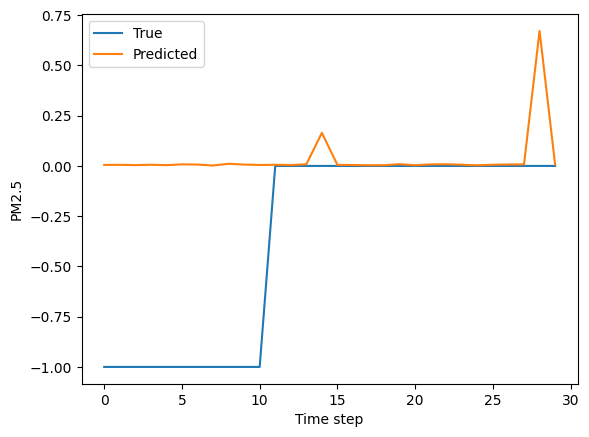

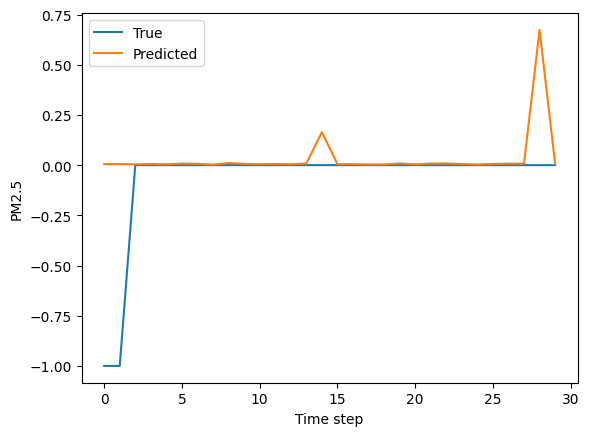

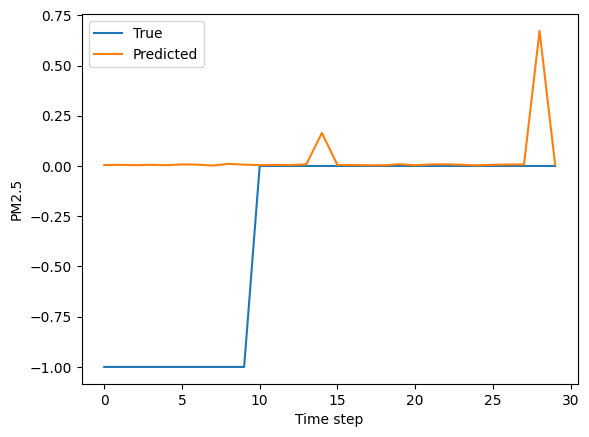

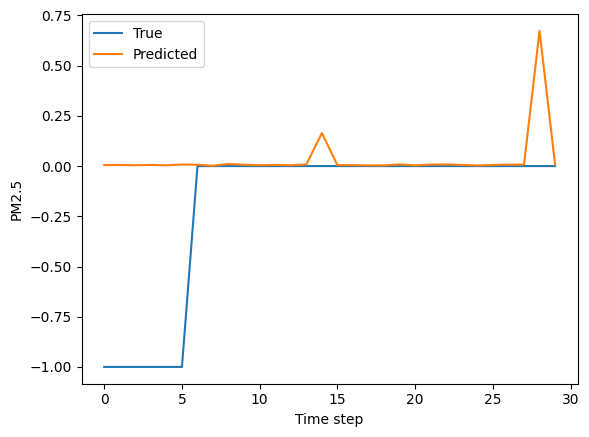

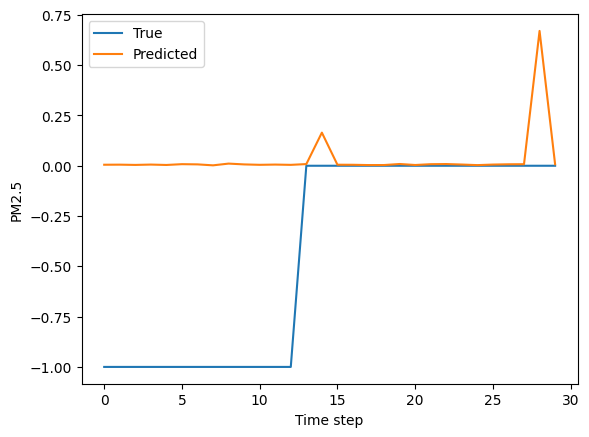

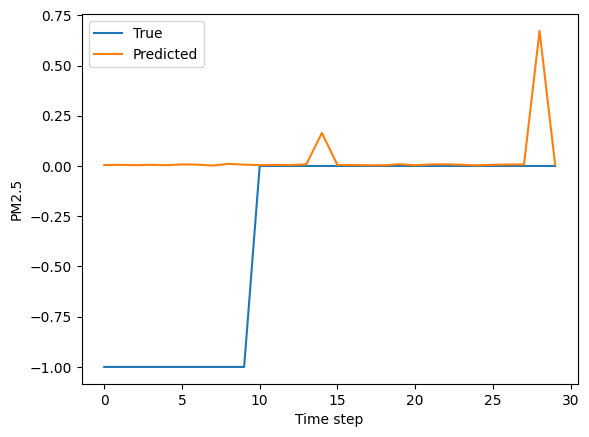

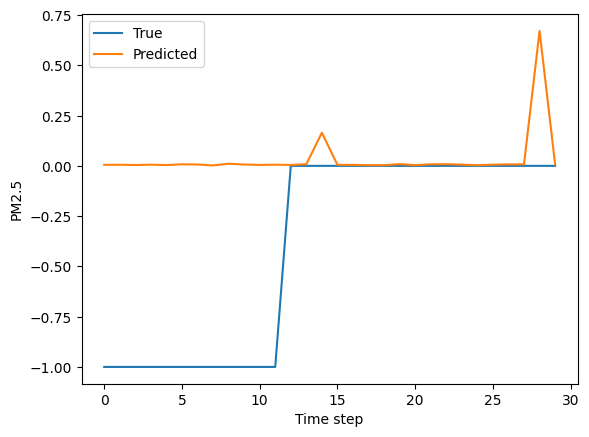

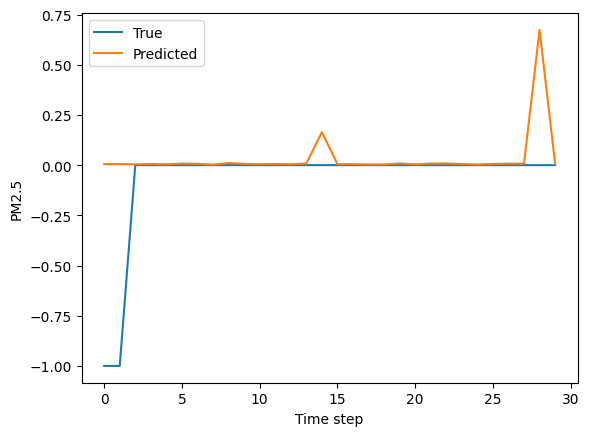

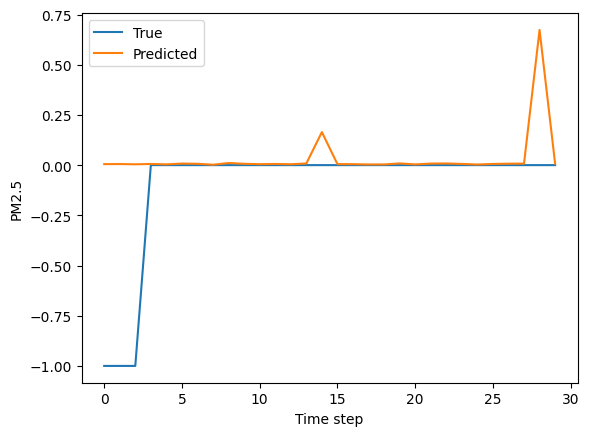

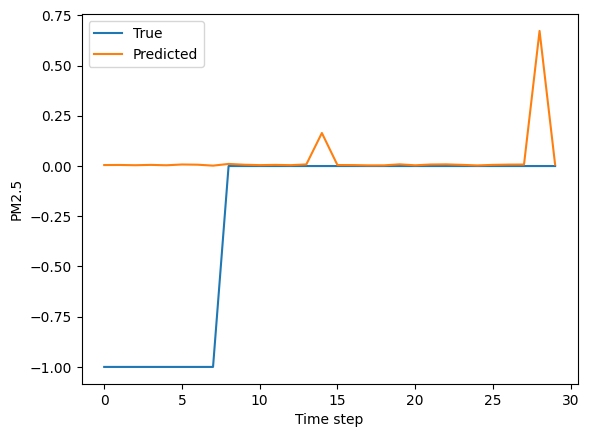

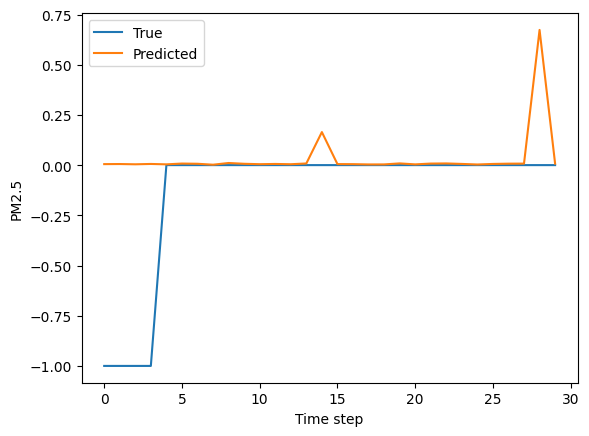

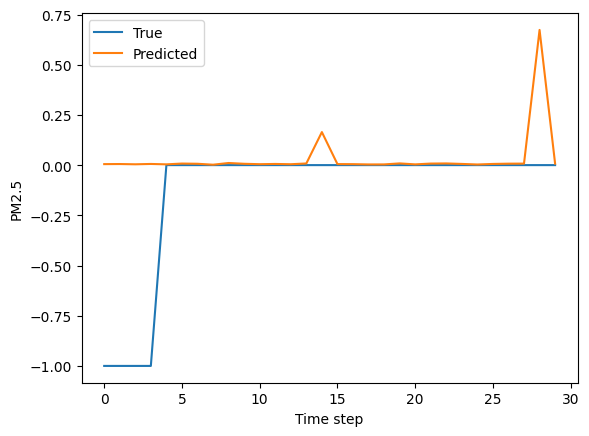

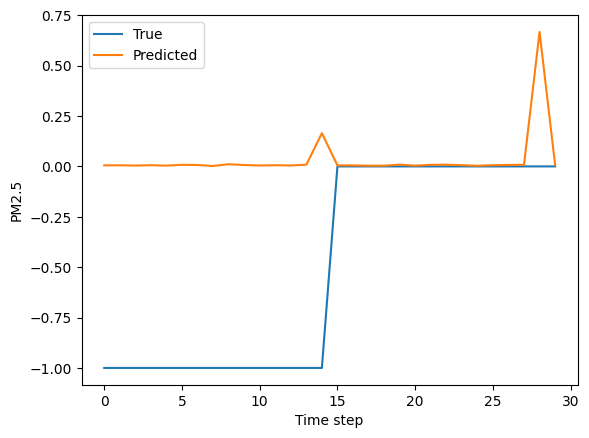

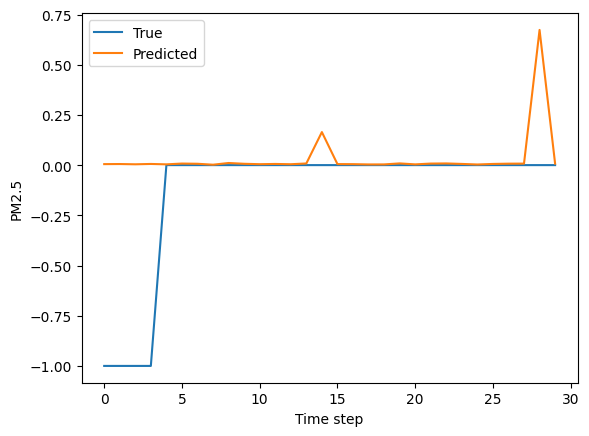

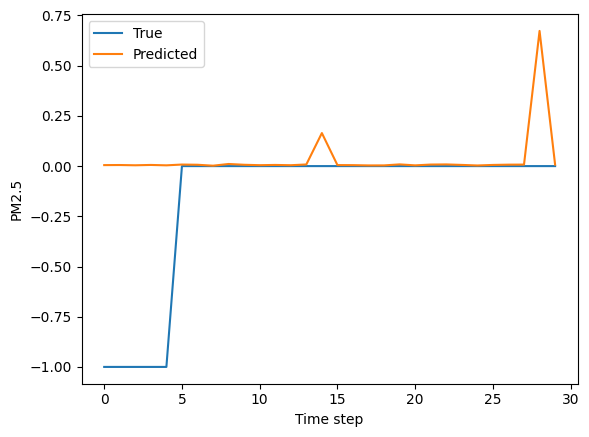

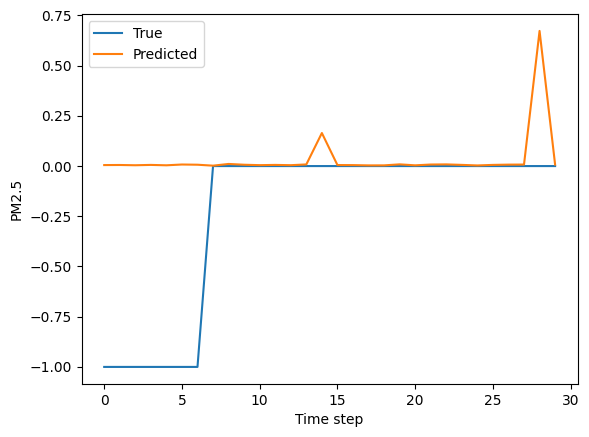

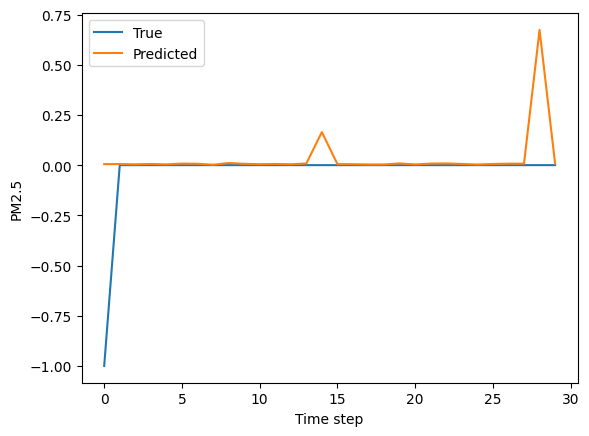

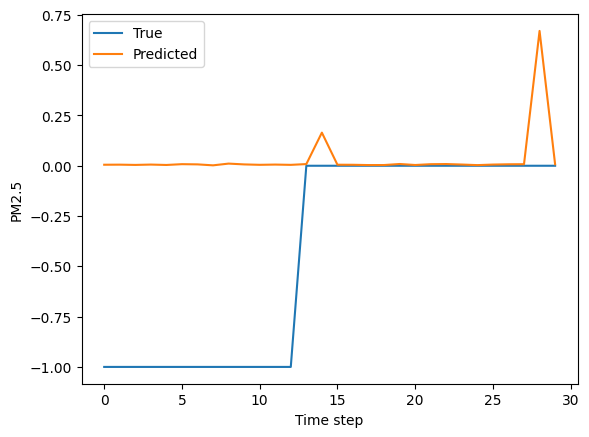

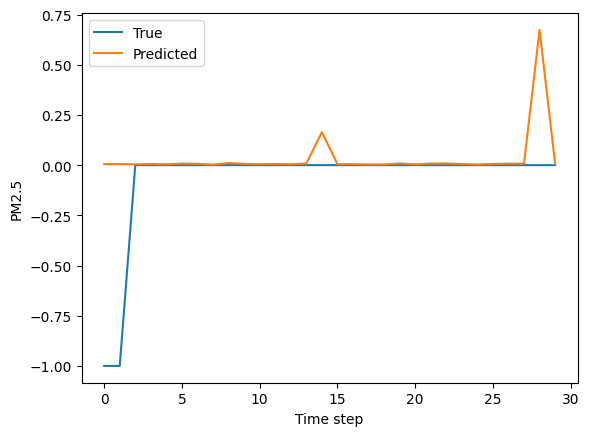

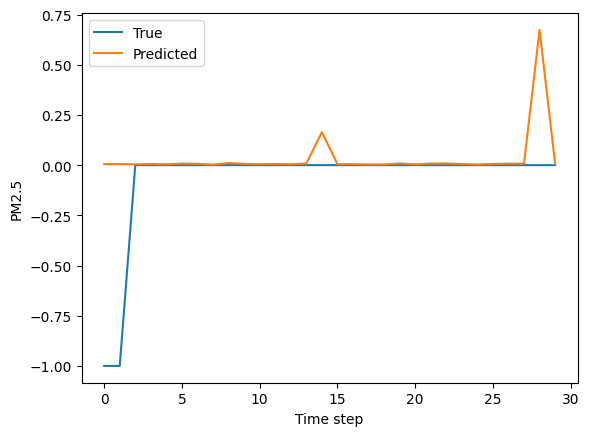

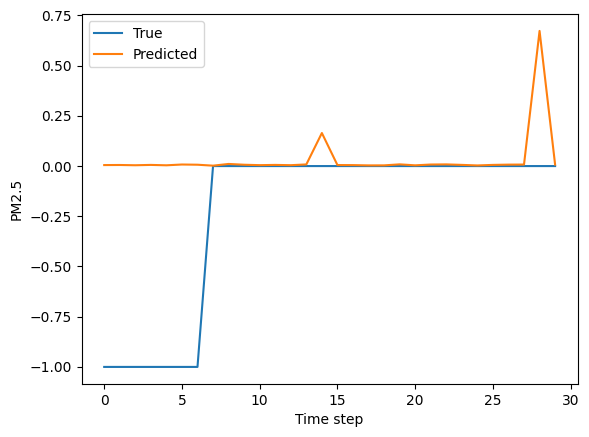

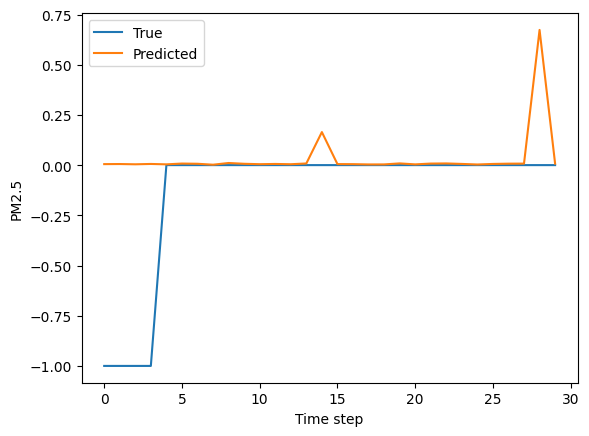

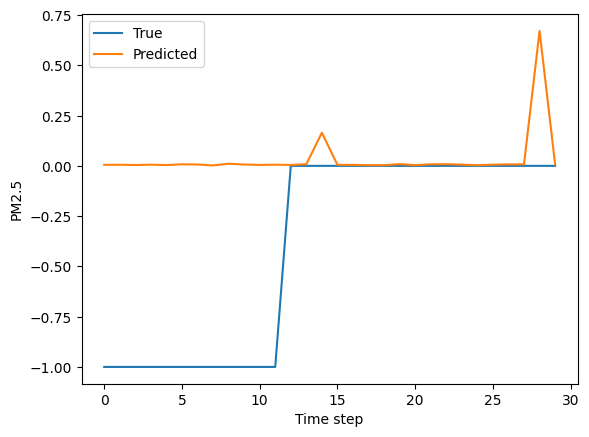

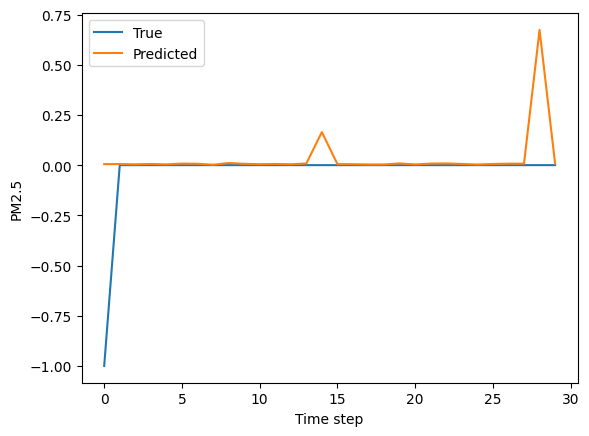

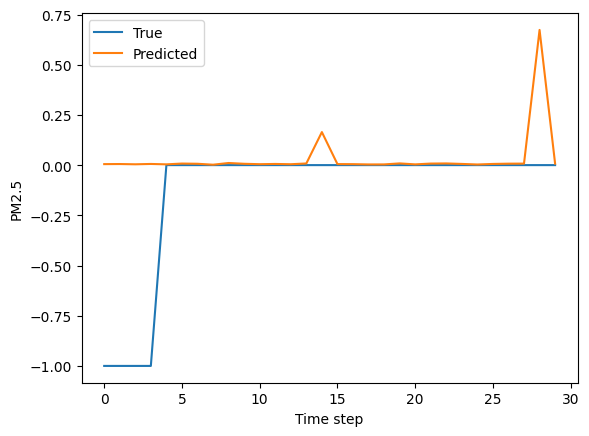

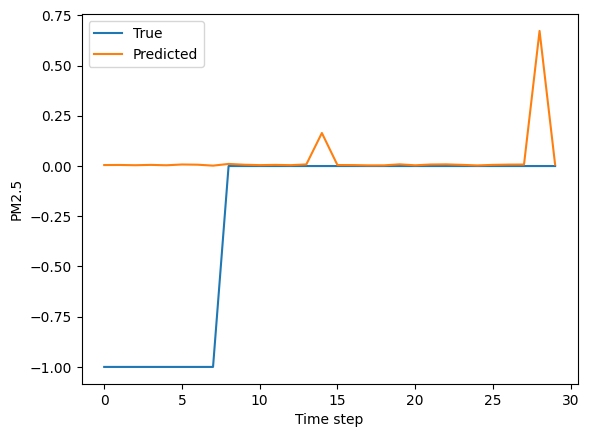

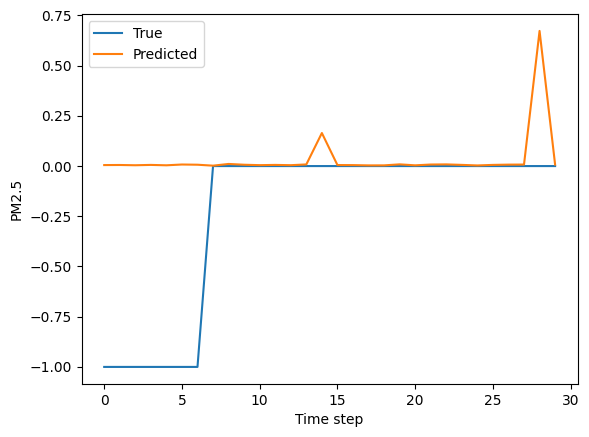

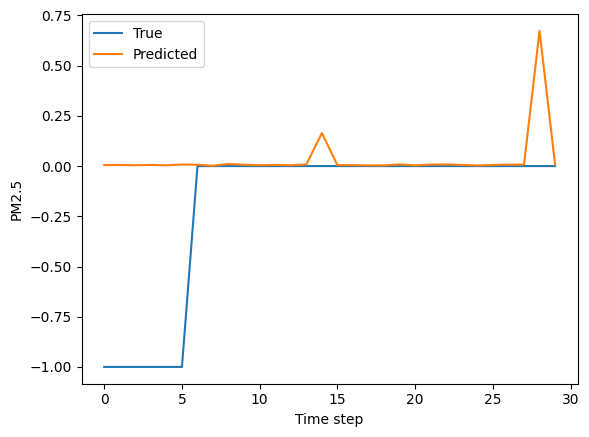

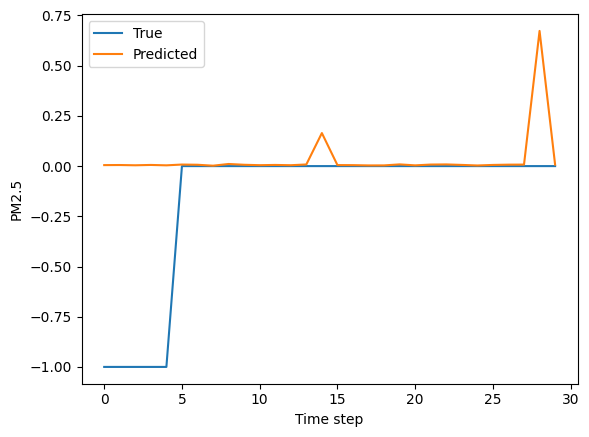

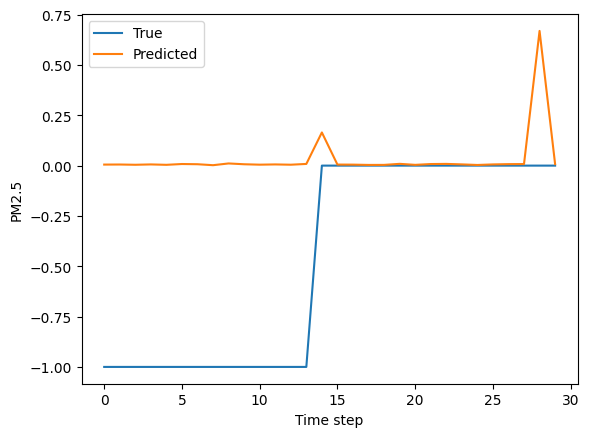

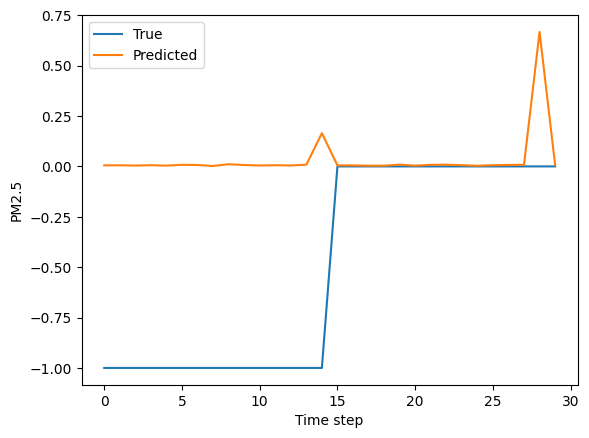

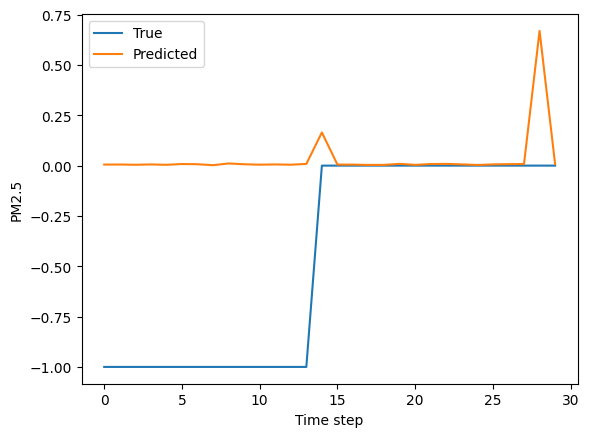

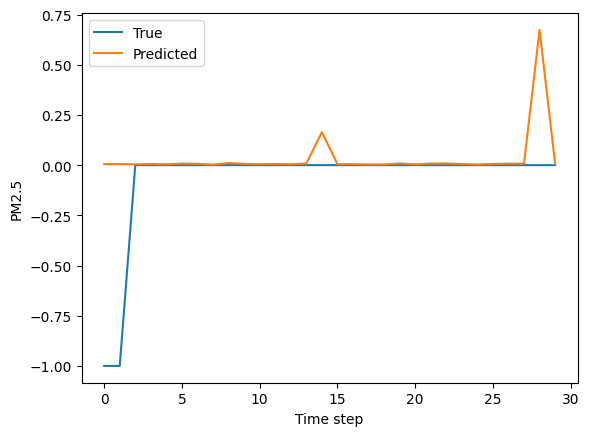

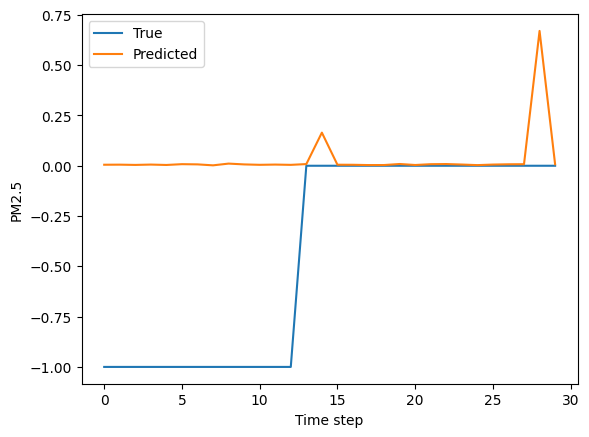

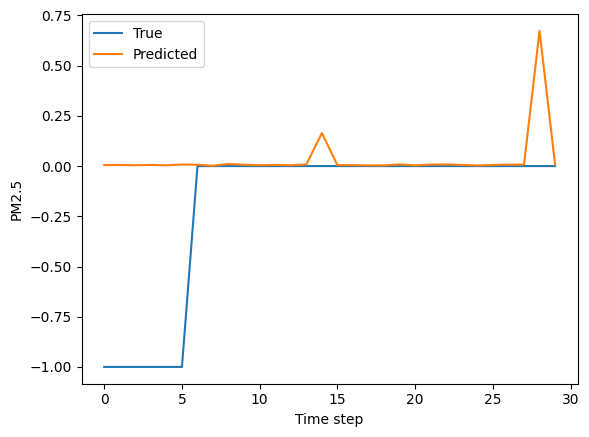

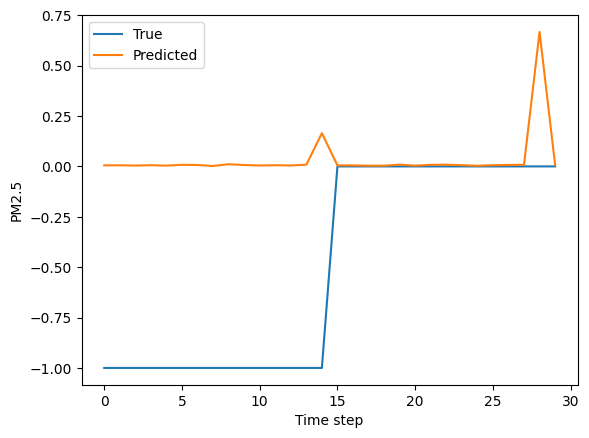

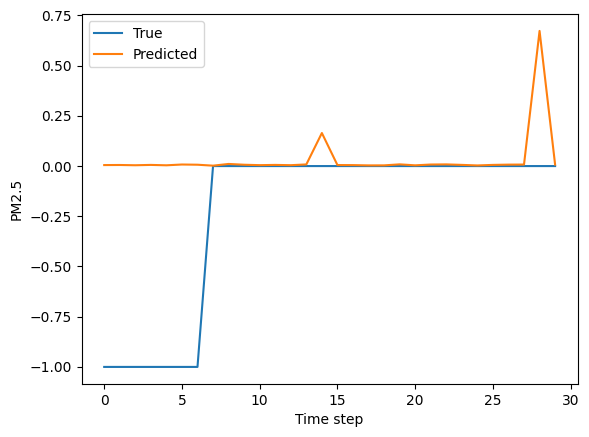

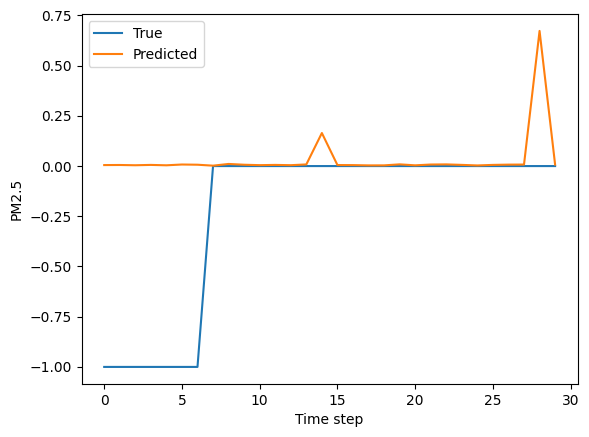

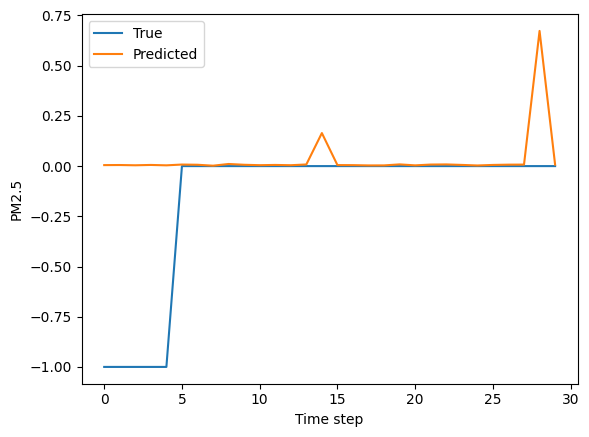

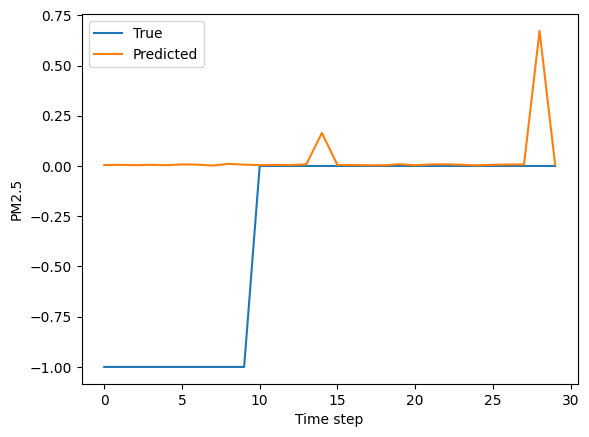

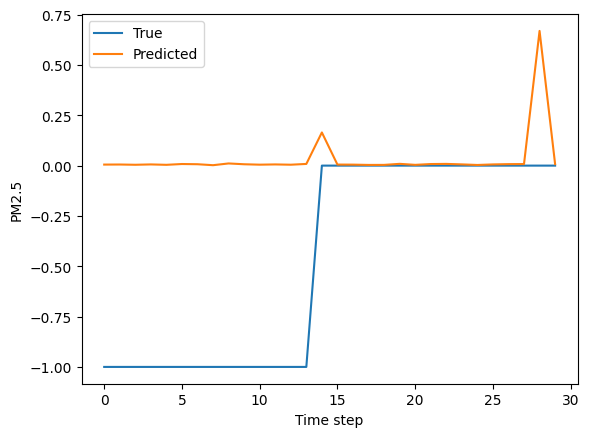

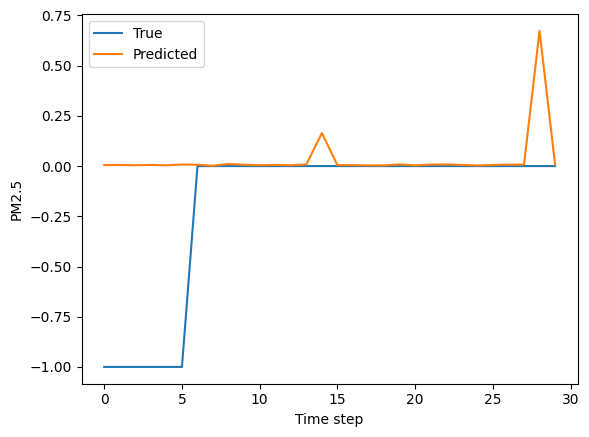

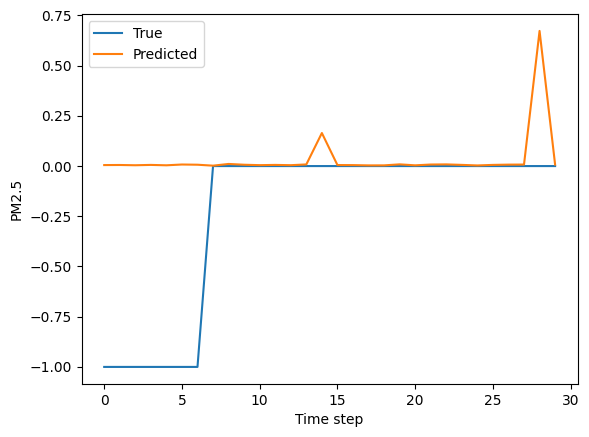

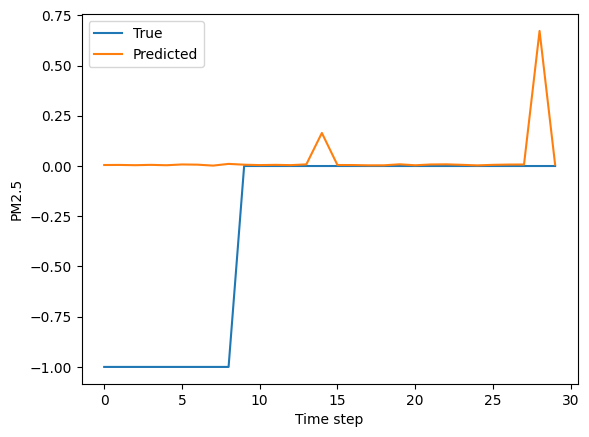

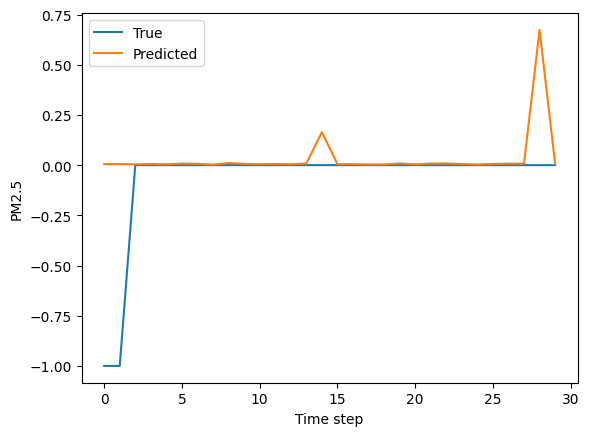

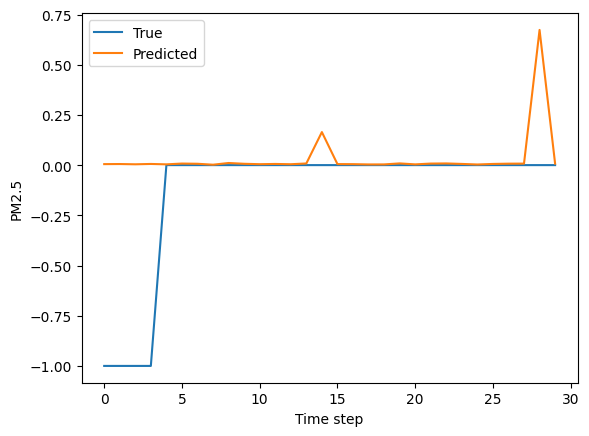

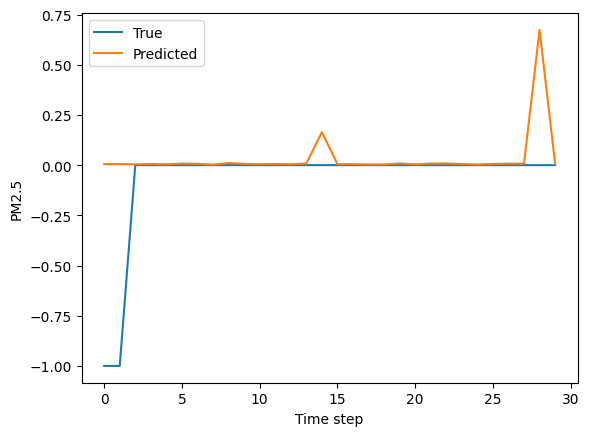

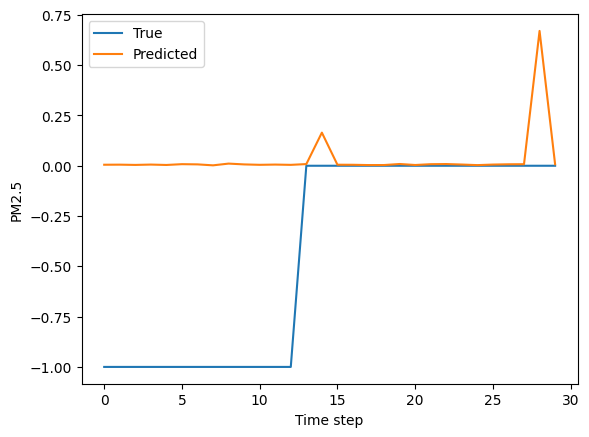

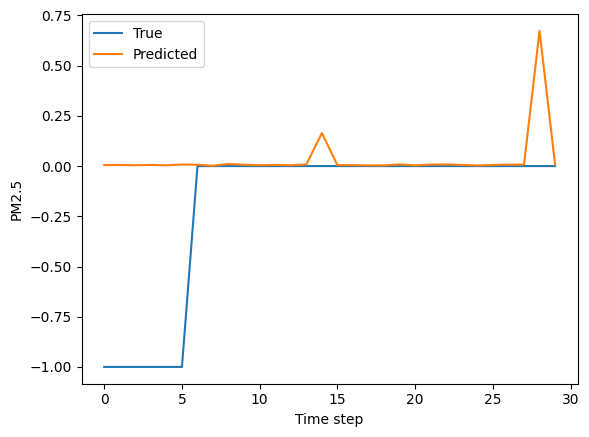

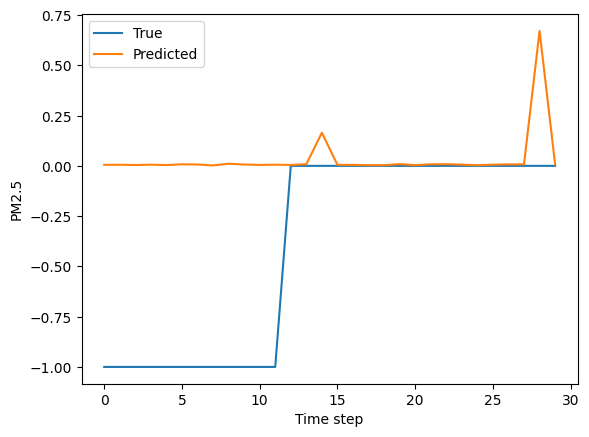

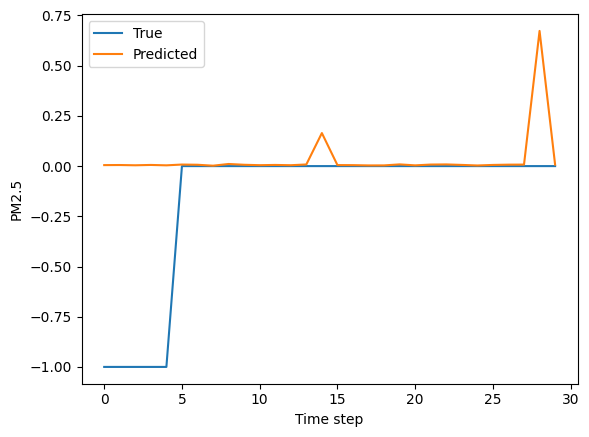

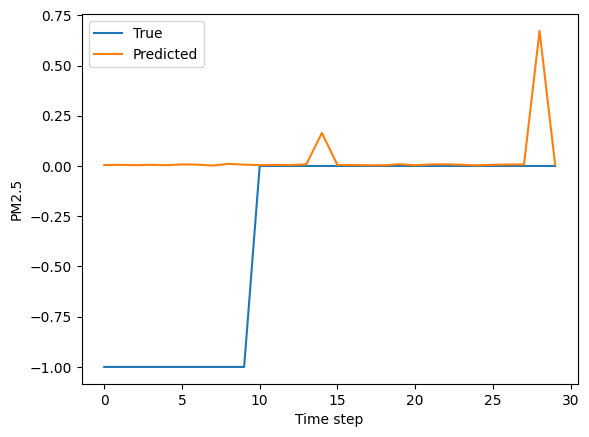

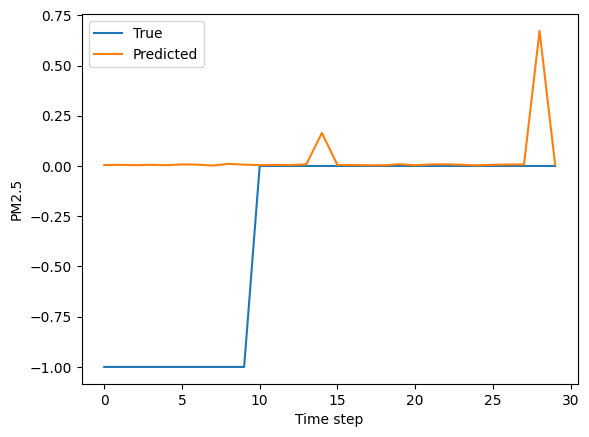

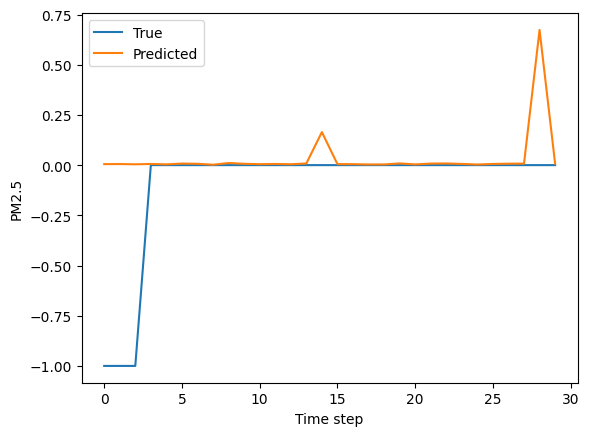

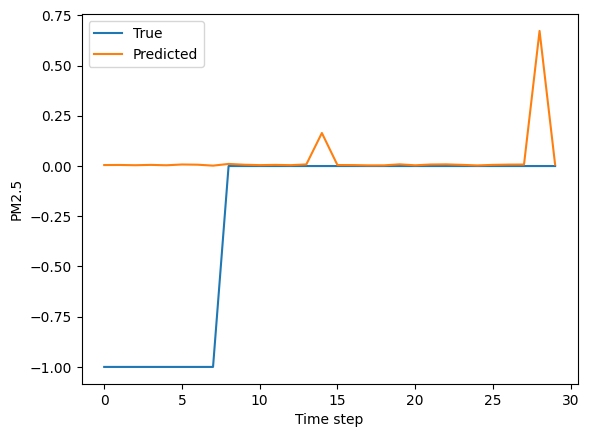

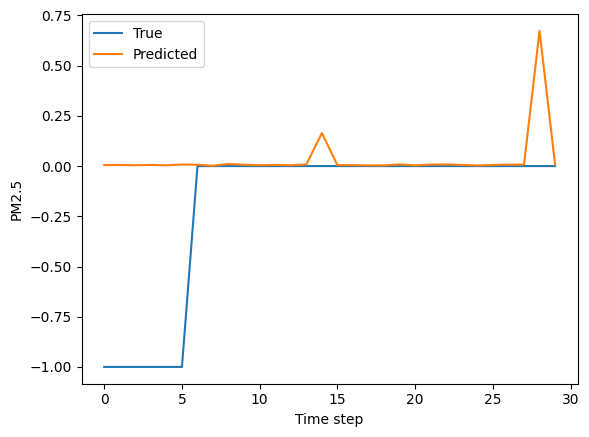

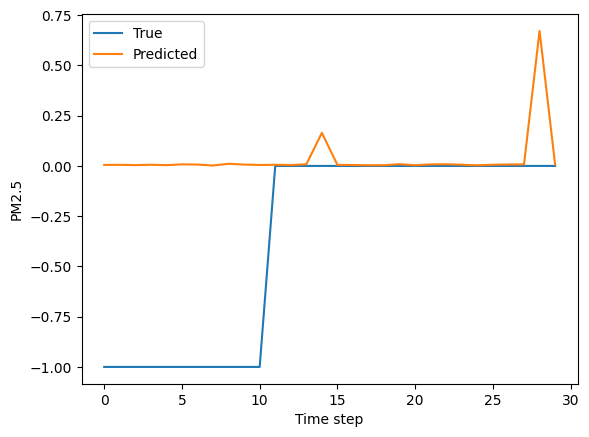

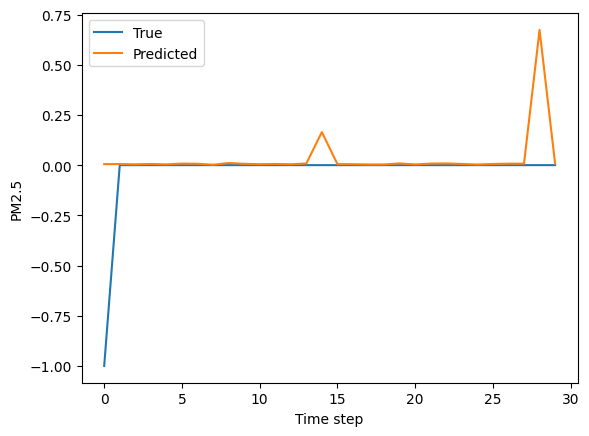

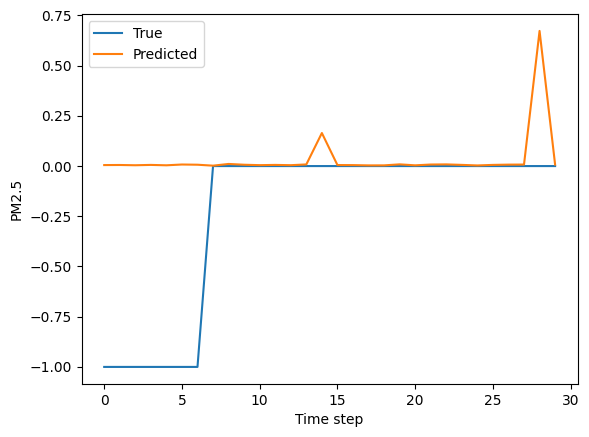

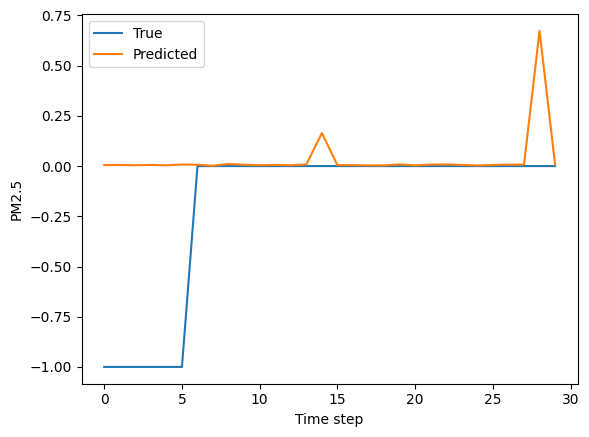

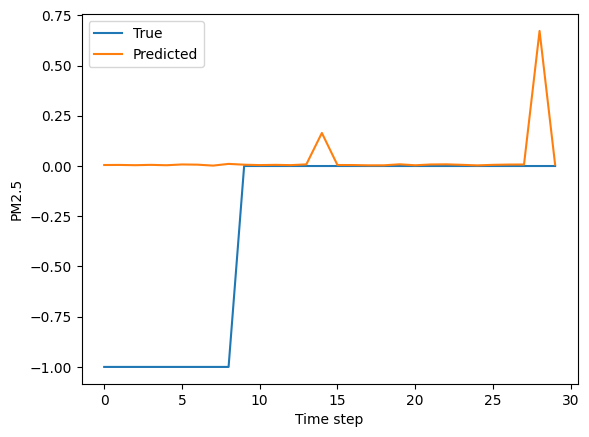

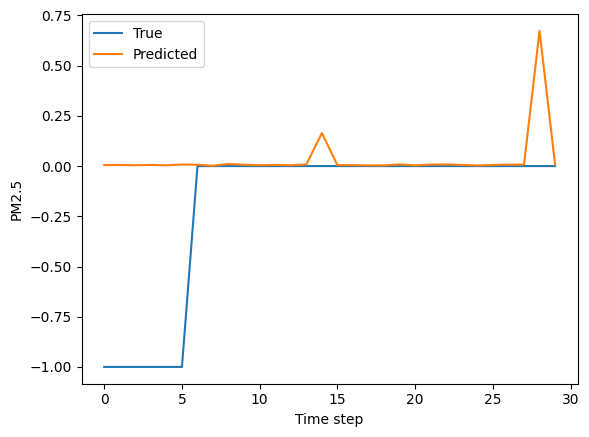

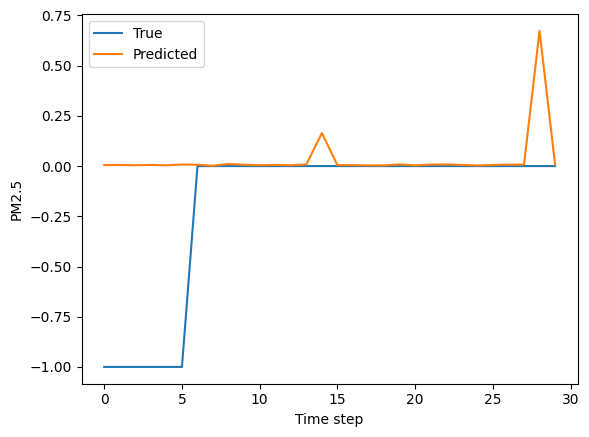

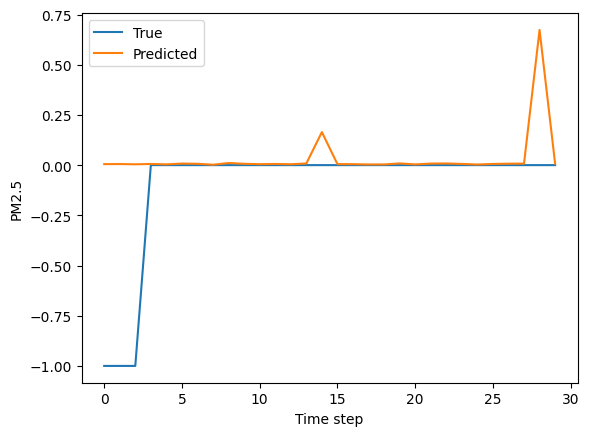

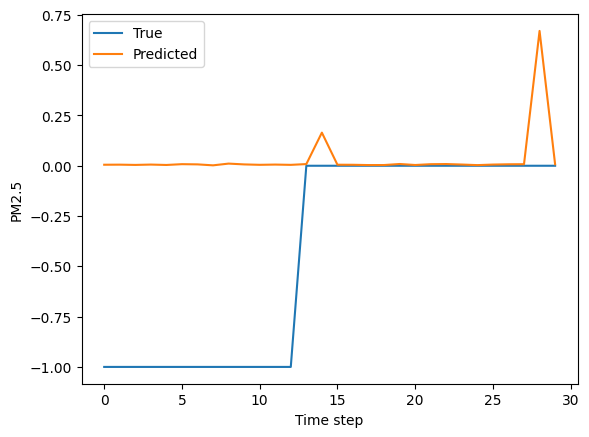

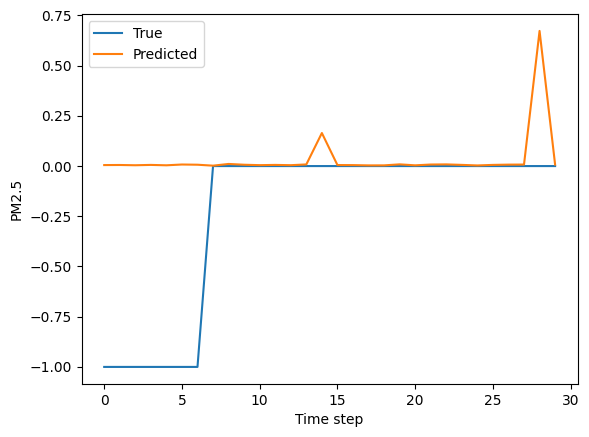

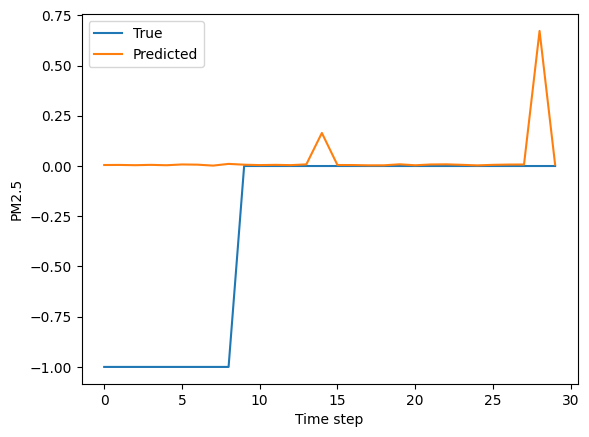

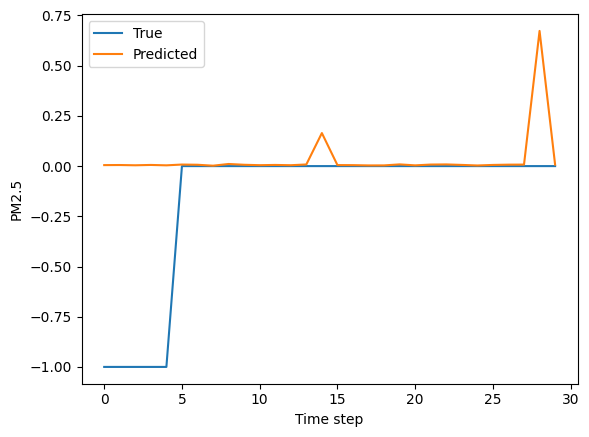

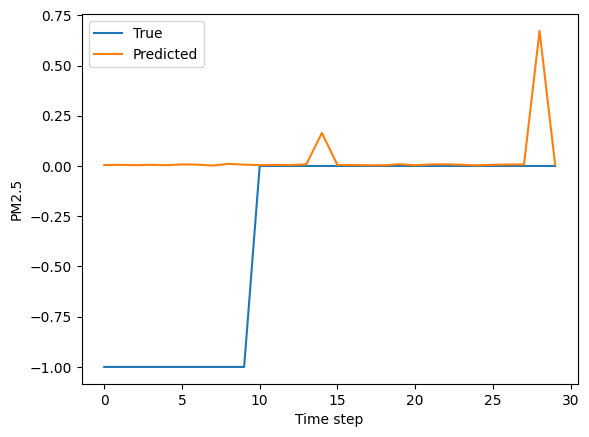

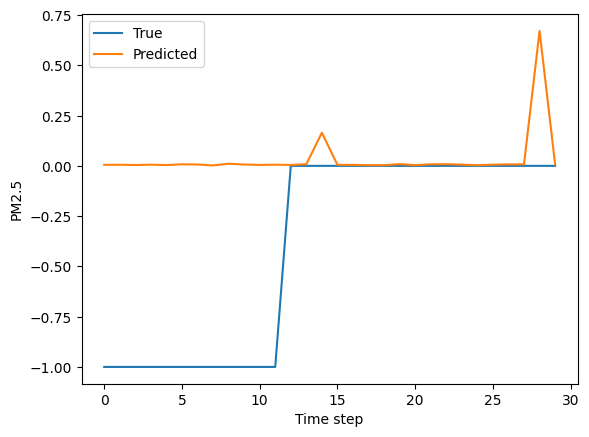

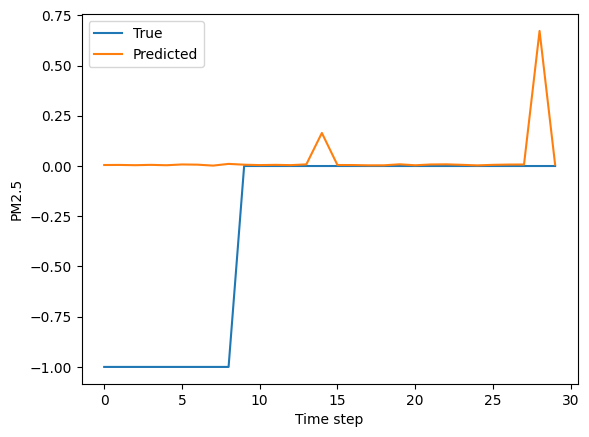

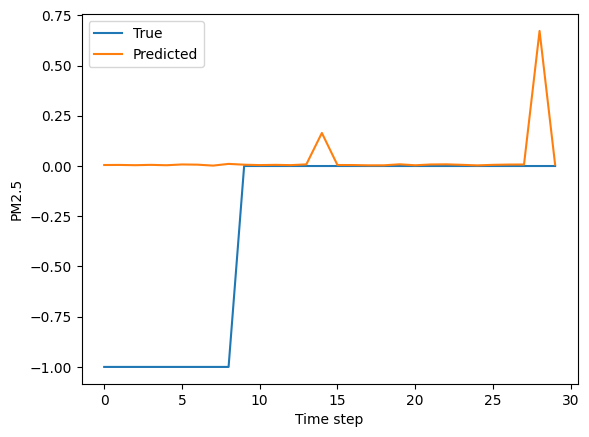

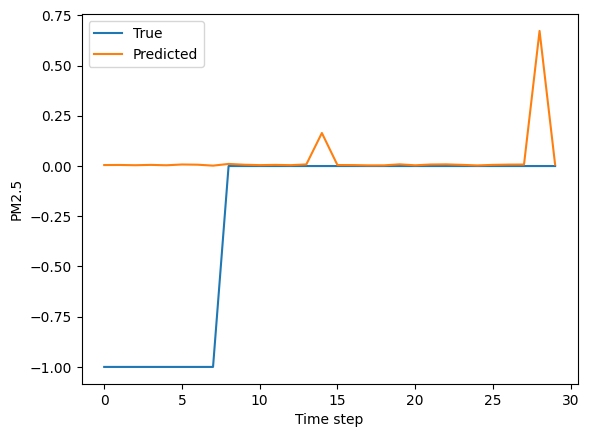

In [127]:
import matplotlib.pyplot as plt

# Define the sequence lengths we want to use for training and testing
sequence_lengths = [10]

model = init_model()

# Make predictions on the test data
y_pred = model.predict(X_test)

# Plot true values and predictions for each sequence
for i in range(len(X_test)):
    # Get true and predicted values for this sequence
    true_vals = y_test[i]
    pred_vals = y_pred[i]

    # Create x-axis values for the plot
    x_vals = np.arange(len(true_vals))

    # Plot the true values and predictions
    plt.plot(x_vals, true_vals, label='True')
    plt.plot(x_vals, pred_vals, label='Predicted')
    plt.legend()
    plt.xlabel('Time step')
    plt.ylabel('PM2.5')

    plt.show()

🏁 **Congratulation**